# Imports and preparation

In [1]:
import os

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from collections import defaultdict

In [5]:
from tqdm import tqdm

In [6]:
import time, gc

In [7]:
import importlib

In [8]:
from itertools import product


In [9]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [10]:
from util import util_pipeline

In [11]:
from util import util_experiment

In [12]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [ ]:
PATH_QUERY = '../data/juris_tcu_index/query.csv'
PATH_QREL =  '../data/juris_tcu_index/qrel.csv'

# Data load

## Query data load

In [61]:
df_query = pd.read_csv(PATH_QUERY)

In [62]:
df_query.shape

(16045, 11)

In [63]:
df_query[df_query['ID']==2845]

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
5618,2845,"Em regra, o pregão é a modalidade de licitação adequada para a concessão remunerada de uso de be...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 478/2016 - Plenário,2016-03-02,RELATOR,MARCOS BEMQUERER


In [64]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,"É ilegal a contagem de tempo ficto de serviço prestado sob a égide da Lei 3.313/1957, proporcion...",Lei Complementar 51/1985 || Lei Ordinária 3313/1957,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Administração Pública não deve exigir dos licitantes ...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,"A contratação de serviços por preços superiores às referências legais (Sinapi e Sicro) deve ser,...",NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos gestores por grave infração à norma legal se a irregu...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar propostas de preço com incidência de encargos majorado...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


## Qrel data load

In [65]:
df_qrel = pd.read_csv(PATH_QREL)

In [66]:
df_qrel.shape

(94809, 3)

In [67]:
df_qrel.head()

,QUERY_ID,DOC_ID,TYPE
0,158,15147,INDEXACAO_EXTRA
1,37,15147,INDEXACAO_EXTRA
2,178,15147,INDEXACAO_EXTRA
3,14564,15147,INDEXACAO_EXTRA
4,9219,15147,INDEXACAO_EXTRA


In [68]:
df_qrel.shape[0]

94809

In [69]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='QUERY_ID').drop('QUERY_ID', axis=1)

In [70]:
df_search_data.shape[0]


94809

In [71]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_DICT')


In [72]:
df_new.head()

,ID,RELEVANCE_DICT
0,5,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,6,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,7,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,8,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,9,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [73]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [74]:

# Selecionar as colunas desejadas
df_search_data = df_new[['ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE', 'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT']]


In [75]:
df_search_data.shape

(16045, 12)

In [76]:
df_search_data = df_search_data.reset_index()

In [77]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [78]:
del df_new

In [79]:
# Function to invert keys and values keeping a list of keys for each value
def invert_dict_with_lists(d):
    inverted_dict = defaultdict(list)
    for k, v in d.items():
        inverted_dict[v].append(k)
    return dict(inverted_dict)

In [80]:
df_search_data['RELEVANCE_DICT_TYPE'] = df_search_data['RELEVANCE_DICT'].apply(invert_dict_with_lists)

In [81]:
df_search_data.shape

(16045, 14)

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [34]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_term', 'uuid': 'S5WlNGiqSXC-79WaqfsddA', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '347mb', 'pri.store.size': '347mb'}

Index: indir_juris_tcu_synonym_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_synonym_related_term', 'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '3045', 'store.size': '348.4mb', 'pri.store.size': '348.4mb'}

Index: indir_juris_tcu_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_related_term', 'uuid': 'i9nzlBQrREyEC7MGT79GBQ', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'do

In [35]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_term',
  'uuid': 'S5WlNGiqSXC-79WaqfsddA',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '347mb',
  'pri.store.size': '347mb'},
 'indir_juris_tcu_synonym_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_synonym_related_term',
  'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '3045',
  'store.size': '348.4mb',
  'pri.store.size': '348.4mb'},
 'indir_juris_tcu_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_related_term',
  'uuid': 'i9nzlBQrREyEC7MGT79GBQ',
  

In [36]:
INDEX_NAME = 'indir_juris_tcu_index'

In [37]:
index = util_elastic.return_index(parm_index_name=INDEX_NAME)


Qtd de documentos 13255

Qtd de embeddings 13255

Documento.id=5: <Document: id=5, content='O termo é "Abono de permanência em serviço".
Abono de permanência em serviço tem definição: "O abono...'>


# Pipelines creation

In [191]:
parm_query = "A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou."

In [38]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline' from '/home/borela/fontes/ind-ir/code/util/util_pipeline.py'>

pype_type: it will be the sufix of file name as we can generate train dataset with different pipelines


In [47]:
%%time
pipe = util_pipeline.return_pipeline_bm25(index)
pipe_type = 'bm25'

CPU times: user 220 µs, sys: 58 µs, total: 278 µs
Wall time: 276 µs


In [50]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Retriever": {"top_k": 150}, 
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": [1131, 342]}}
                            }}})


CPU times: user 2.93 ms, sys: 0 ns, total: 2.93 ms
Wall time: 672 ms


In [168]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Retriever": {"top_k": 2}, 
 "filters":{"id": 652}})

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 3.86 ms


In [190]:
parm_query2 = 'Todos os documentos apresentados pelos proponentes durante as sessões licitatórias devem ser rubricados por todas as licitantes presentes, devendo-se registrar na ata da sessão eventual fato impeditivo.'

In [214]:
doc_returned = pipe.run(query=parm_query2, 
 params={"Retriever": {"top_k": 10000}, 
 "filters":{"id": 652}})

In [215]:
doc_returned.keys()

dict_keys(['documents', 'root_node', 'params', 'query', 'node_id'])

In [216]:
round(doc_returned['documents'][0].score,3)

IndexError: list index out of range

In [198]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Retriever': {'top_k': 1000}, 'filters': {'id': 652}}
Consulta: Todos os documentos apresentados pelos proponentes durante as sessões licitatórias devem ser rubricados por todas as licitantes presentes, devendo-se registrar na ata da sessão eventual fato impeditivo.
Qtd documentos retornados: 0


In [51]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Retriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1131, 342]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 8
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU".
Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (8):
<Document: id=775, content='O termo é "Responsabilidade".
Responsabilidade tem definição: "Qualidade de quem responde pelos próp...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', 0.981022770821533]
1 : ['Desestatização', '414', 0.9236313236529244]
2 : ['Gestão administrativa', '15273', 0.8770019134030279]
3 : ['Contrato administrativo', '331', 0.8510101027285571]
4 : [

In [52]:
doc_returned['documents'][0].id,  doc_returned['documents'][0].meta['id'],doc_returned['documents'][0].meta['name'], doc_returned['documents'][0].score

('5095', 5095, 'Competência do TCU', 0.981022770821533)

In [53]:
type(doc_returned['documents'])

list

In [ ]:
doc_returned['documents'][0].meta.keys()

dict_keys(['has_scope_note', 'text_scope_note', 'text_example', 'text_specialization', 'text_synonym', 'has_english_translation', 'has_spanish_translation', 'num_word', 'count_index_subtheme', 'has_specialization', 'count_index_area', 'id', 'text_definition', 'has_related_term', 'has_generalization', 'class', 'text_spanish_translation', 'text_related_term', 'has_synonym', 'num_tokens_monot5_3b', 'date_reference', 'has_example', 'has_definition', 'count_index_theme', 'len_text_char_log', 'num_tokens_minilm', 'count_index_total', 'len_text_char', 'text_english_translation', 'text_generalization', 'count_index_extra', 'name'])

In [39]:
ranker_type = 'MT5_3B'

In [ ]:
%%time
pipe = util_pipeline.return_pipeline_join_bm25_sts_reranker(index, ranker_type, parm_limit_query_size=350)
pipe_type = 'join_sts_bm25_ranker_monot5_3b'

In [ ]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 10},
         "StsRetriever": {"top_k": 10},
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": [1131, 342]}}
                            }}})


CPU times: user 829 ms, sys: 247 ms, total: 1.08 s
Wall time: 1.13 s


In [ ]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1131, 342]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 8
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU". Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (8):
<Document: id=414, content='O termo é "Desestatização".
Desestatização tem definição: "É a retirada da presença do Estado de ati...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', -1.4214444160461426]
1 : ['Responsabilidade', '775', -2.1346242427825928]
2 : ['Finanças públicas', '629', -4.974789142608643]
3 : ['Gestão administrativa',

# Experiments

In [ ]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [ ]:
query_data = df_search_data.iloc[0]

In [ ]:
query_data['TEXT'], query_data['RELEVANCE_DICT']

('SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fundamento na Lei nº 3.738, de 04/04/60, as vantagens previstas no art. 184 da Lei nº 1.711, de 28/10/52.',
 {1298: 'INDEXACAO_EXTRA',
  15340: 'INDEXACAO_EXTRA',
  15961: 'INDEXACAO_EXTRA',
  1131: 'AREA',
  5106: 'SUBTEMA',
  1113: 'TEMA'})

In [ ]:
list(query_data['RELEVANCE_DICT'].keys())

[1298, 15340, 15961, 1131, 5106, 1113]

In [ ]:
%%time
doc_returned = pipe.run(query=query_data['TEXT'], 
 params={"Retriever": {"top_k": 150}, "filters":{"count_index_area": {"$gte": 1}}})


CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 11.8 ms


In [ ]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Retriever": {"top_k": 150}, 
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": list(query_data['RELEVANCE_DICT'].keys())}}
                            }}})

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 7.59 ms


In [ ]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Retriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1298, 15340, 15961, 1131, 5106, 1113]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 9
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU".
Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (9):
<Document: id=775, content='O termo é "Responsabilidade".
Responsabilidade tem definição: "Qualidade de quem responde pelos próp...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', 0.9849794090993254]
1 : ['Desestatização', '414', 0.9400033944545403]
2 : ['Gestão administrativa', '15273', 0.8990803951959326]
3 : ['Convênio', '342', 0.8861608632

# Generate train data

Bm25 

        100%|██████████| 16045/16045 [08:42<00:00, 30.70it/s]CPU times: user 2min 25s, sys: 2.83 s, total: 2min 28s
        Wall time: 8min 42s

MT5_3B

        100%|██████████| 16045/16045 [33:08:51<00:00,  7.44s/it]   CPU times: user 20h 6min 27s, sys: 12h 37min 47s, total: 1d 8h 44min 14s
        Wall time: 1d 9h 8min 51s

In [60]:
%%time
max_count_negative = 2
list_train_data = []
for cnt_row, (ndx, row_query) in tqdm(enumerate(df_search_data.iterrows()), mininterval=10, total=df_search_data.shape[0]):
    # print(f"cnt {cnt} query_id {row_query['ID']} ")
    set_not_relevant = set()
    list_not_in_docid = list(row_query['RELEVANCE_DICT'].keys())
    for type_relevance in ['AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA']:
        if type_relevance in row_query['RELEVANCE_DICT_TYPE']: # INDEXACAO_EXTRA pode não existir
            for cnt_doc_in_type, doc_id in enumerate(row_query['RELEVANCE_DICT_TYPE'][type_relevance]):
                relevant_data = (row_query['ID'], doc_id, 1, type_relevance)
                # print(f"     {relevant_data}")
                list_train_data.append(relevant_data)
                # Encontra primeiro encontrado para não relevante    
                if type_relevance == 'AREA':
                    type_field_count = "count_index_area"
                elif type_relevance == 'TEMA':
                    type_field_count = "count_index_theme"
                elif type_relevance == 'SUBTEMA':
                    type_field_count = "count_index_subtheme"
                elif type_relevance == 'INDEXACAO_EXTRA':
                    type_field_count = "count_index_extra"
                else:
                    raise Exception(f"type_relevance {type_relevance} not expected!")     
                doc_returned = pipe.run(query=row_query['TEXT'], 
                                    # params={"Retriever": {"top_k": max_count_negative}, # extra may have 9 values
                                    params={"Bm25Retriever": {"top_k": max_count_negative*5},
                                            "StsRetriever": {"top_k": max_count_negative*5},
                                            "filters":{"$and": {type_field_count: {"$gte": 1},
                                            "$not": {"id": {"$in": list_not_in_docid}}
                                            }}})
                if len(doc_returned['documents']) == 0:
                    raise Exception(f"Not found negative examples!")
                count_negative = 0
                for ndx, docto in enumerate(doc_returned['documents']):
                    if count_negative >= max_count_negative:
                        break   
                    if docto.meta['id'] not in set_not_relevant:
                        count_negative += 1
                        set_not_relevant.add(docto.meta['id'])
                        list_not_in_docid.append(docto.meta['id'])
                        not_relevant_data = (row_query['ID'], docto.meta['id'], 0, type_relevance)
                        # print(f"     {not_relevant_data}")                    
                        list_train_data.append(not_relevant_data)
                if count_negative < max_count_negative:
                    print(f"Less negative {count_negative} than {max_count_negative} for query_id {row_query['ID']} in {type_relevance}")
    # if cnt_row > 2: break



100%|██████████| 16045/16045 [33:08:51<00:00,  7.44s/it]   

CPU times: user 20h 6min 27s, sys: 12h 37min 47s, total: 1d 8h 44min 14s
Wall time: 1d 9h 8min 51s


In [61]:
df = pd.DataFrame(list_train_data, columns= ['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE'])

In [62]:
df.shape
# bm25 (284376, 4)

(284376, 4)

In [63]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE
0,5,1131,1,AREA
1,5,5095,0,AREA
2,5,775,0,AREA
3,5,1113,1,TEMA
4,5,14871,0,TEMA


In [64]:
pipe_type

'join_sts_bm25_ranker_monot5_3b'

In [65]:
path_thain =  f'../data/train_juris_tcu_index/train_data_juris_tcu_index_{pipe_type}.csv'

In [66]:
df.to_csv(path_thain, sep=',', index=False)

## Concatenate texts

In [17]:
PATH_LOCAL_DATA = '../../data/juris_tcu_index'

In [18]:
PATH_QUERY_DATA = f"{PATH_LOCAL_DATA}/query.csv"

In [19]:
PATH_DOC_DATA = f"{PATH_LOCAL_DATA}/doc.csv"

In [20]:
# path_data = '/content/drive/MyDrive/treinamento/202301_IA368DD/indir/data/train_data_juris_tcu_index_bm25.csv'
PATH_TRAIN_DATA = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index_join_sts_bm25_ranker_monot5_3b.csv"

In [ ]:
PATH_VALID_DATA = f"../../data/train_juris_tcu_index/juris_tcu_index_validation_query_id.csv"

In [21]:
PATH_TRAIN_DATA_GENERATED = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index.csv"

In [22]:
PATH_TRAIN_DATA_GENERATED_V2 = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index_v2.csv"

In [23]:
os.path.exists(PATH_TRAIN_DATA)

False

In [ ]:
df = pd.read_csv(PATH_TRAIN_DATA)

In [ ]:
df.shape

(284376, 4)

In [ ]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE'], dtype='object')

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE
0,5,1131,1,AREA
1,5,5095,0,AREA
2,5,775,0,AREA
3,5,1113,1,TEMA
4,5,14871,0,TEMA


In [ ]:
df_query = pd.read_csv(PATH_QUERY_DATA)

In [ ]:
df_query.shape

(16045, 11)

In [ ]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,É ilegal a contagem de tempo ficto de serviço ...,Lei Complementar 51/1985 || Lei Ordinária 3313...,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Adm...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,A contratação de serviços por preços superiore...,NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos ges...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar prop...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


In [ ]:
df_doc = pd.read_csv(PATH_DOC_DATA)

In [ ]:
df_doc.shape

(13255, 28)

merge with doc

In [ ]:
df = df.merge(df_doc[['ID','TEXT']], how='left', left_on='DOC_ID', right_on='ID').drop('ID',axis=1)

In [ ]:
df.rename(columns={'TEXT': 'DOC_TEXT'},inplace=True)

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT
0,5,1131,1,AREA,"O termo é ""Pessoal"".\nPessoal tem nota de esco..."
1,5,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência d..."
2,5,775,0,AREA,"O termo é ""Responsabilidade"".\nResponsabilidad..."
3,5,1113,1,TEMA,"O termo é ""Pensão especial"".\nPensão especial ..."
4,5,14871,0,TEMA,"O termo é ""Concessão (Pessoal)"".\nConcessão (P..."


In [ ]:
df = df.merge(df_query[['ID','TEXT']], how='left', left_on='QUERY_ID', right_on='ID').drop('ID',axis=1)

In [ ]:
df.rename(columns={'TEXT': 'QUERY_TEXT'},inplace=True)

In [ ]:
df.shape

(284376, 6)

In [ ]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT,QUERY_TEXT
0,5,1131,1,AREA,"O termo é ""Pessoal"".\nPessoal tem nota de esco...",SÚMULA TCU 1: Não se compreendem como vencimen...
1,5,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência d...",SÚMULA TCU 1: Não se compreendem como vencimen...
2,5,775,0,AREA,"O termo é ""Responsabilidade"".\nResponsabilidad...",SÚMULA TCU 1: Não se compreendem como vencimen...
3,5,1113,1,TEMA,"O termo é ""Pensão especial"".\nPensão especial ...",SÚMULA TCU 1: Não se compreendem como vencimen...
4,5,14871,0,TEMA,"O termo é ""Concessão (Pessoal)"".\nConcessão (P...",SÚMULA TCU 1: Não se compreendem como vencimen...


## Remove validation queries

In [ ]:
df_validation = pd.read_csv(PATH_VALID_DATA)

In [ ]:
df_validation.shape

(100, 1)

In [ ]:
df_validation.head(5)

,QUERY_ID
0,4273
1,36
2,1650
3,22806
4,49608


In [ ]:
list_query_id_valid = df_validation['QUERY_ID'].to_list()

triplas: query + id_doc + ind_relevancia (1, se positivo,  e 0 se negativo)

In [ ]:
df.shape

(284376, 6)

In [ ]:
df = df[~df['QUERY_ID'].isin(list_query_id_valid)]


In [ ]:
df.shape

(282636, 6)

## Some information

Verificando correção do arquivo!

In [ ]:
print(df.isnull().sum())

QUERY_ID          0
DOC_ID            0
RELEVANCE         0
TYPE_RELEVANCE    0
DOC_TEXT          0
QUERY_TEXT        0
Length: 6, dtype: int64


In [ ]:
df[['QUERY_TEXT','DOC_TEXT']].applymap(len).describe()

,QUERY_TEXT,DOC_TEXT
count,282636.0000000,282636.0000000
mean,314.4387445,971.9820688
std,159.8934908,671.0375228
min,41.0000000,86.0000000
25%,211.0000000,595.0000000
50%,286.0000000,812.0000000
75%,383.0000000,1162.0000000
max,4212.0000000,3739.0000000


For each relevant there are 2 not relevants

In [ ]:
df['RELEVANCE'].describe()

count    282636.0000000
mean          0.3333333
std           0.4714054
min           0.0000000
25%           0.0000000
50%           0.0000000
75%           1.0000000
max           1.0000000
Name: RELEVANCE, Length: 8, dtype: float64

In [ ]:
df.to_csv(PATH_TRAIN_DATA_GENERATED, index=False)

# Investigate quantitative data per doc_id 

In [1]:
import matplotlib.pyplot as plt

In [313]:
#PATH_TRAIN_DATA = f"../data/train_juris_tcu_index/train_data_juris_tcu_index_all_data.csv"
PATH_TRAIN_DATA = f"../data/train_juris_tcu_index/train_data_juris_tcu_index_limit_50_per_doc.csv"

In [314]:
os.path.exists(PATH_TRAIN_DATA)

True

In [315]:
df = pd.read_csv(PATH_TRAIN_DATA)

In [316]:
df.shape

(86804, 6)

In [317]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

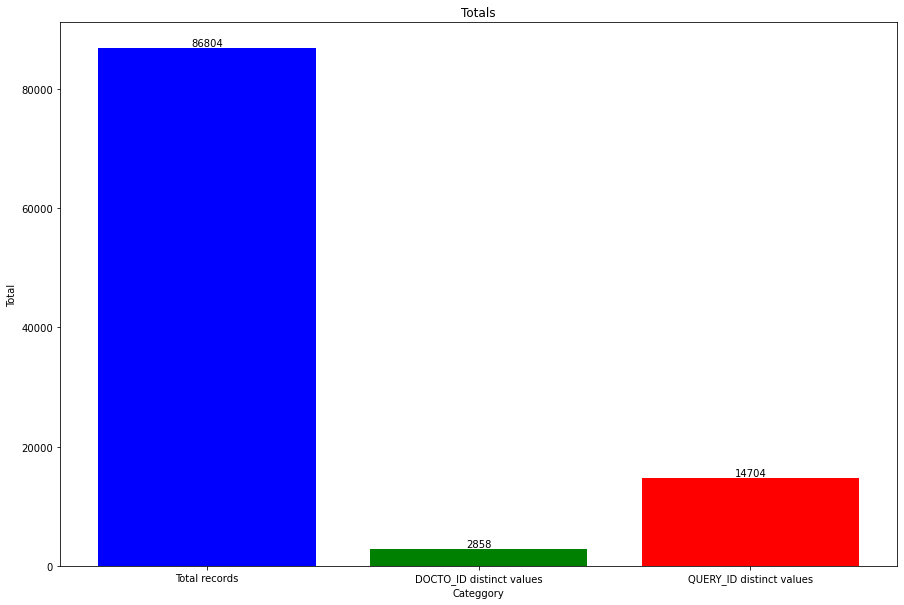

In [318]:
# Calcular os valores
total_registros = len(df)
valores_distintos_docto = df['DOC_ID'].nunique()
valores_distintos_query = df['QUERY_ID'].nunique()

# Criar os rótulos das barras
labels = ['Total records', 'DOCTO_ID distinct values', 'QUERY_ID distinct values']

# Criar os valores das barras
valores = [total_registros, valores_distintos_docto, valores_distintos_query]

# Definir as cores das barras
cores = ['blue', 'green', 'red']

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
plt.bar(labels, valores, color=cores)
plt.title('Totals')
plt.xlabel('Categgory')
plt.ylabel('Total')

# Adicionar os valores sobre as barras
for i, valor in enumerate(valores):
    plt.text(i, valor, str(valor), ha='center', va='bottom')

plt.show()


In [294]:
list_property = ['TYPE_RELEVANCE']
colors = ['blue', 'green', 'red']

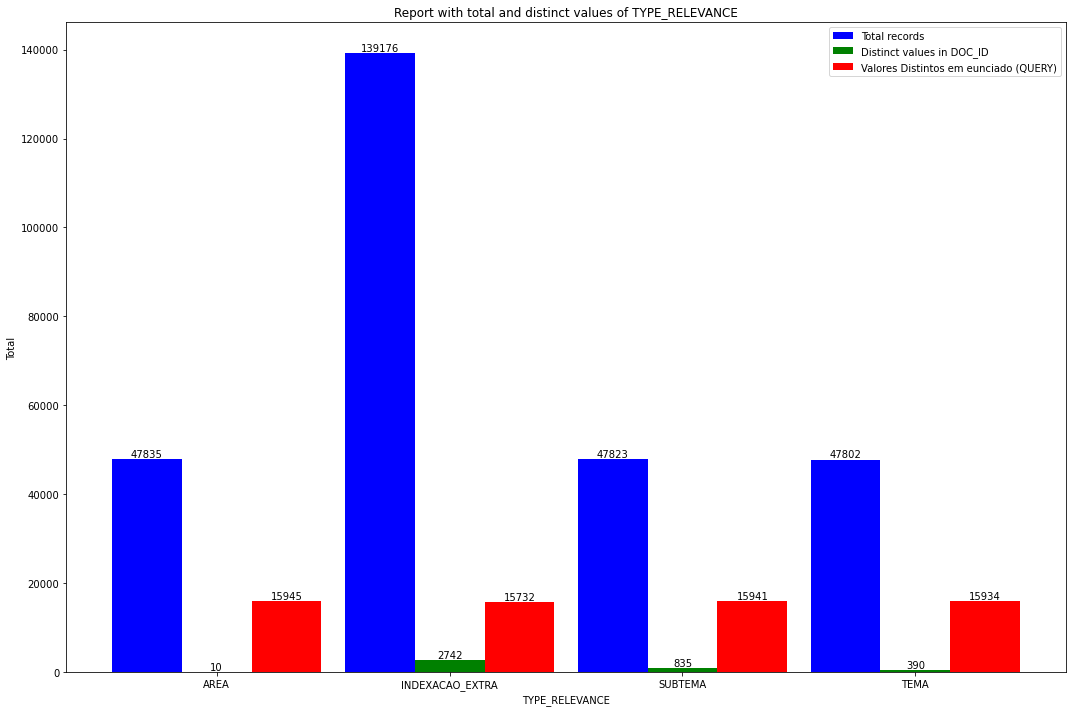

In [295]:

for property_name in list_property:
    # Agrupar o DataFrame por valor da propriedade
    grouped_data = df.groupby(property_name)

    # Calcular o total de registros, valores distintos em 'DOC_ID' e valores distintos em 'QUERY_ID' para cada valor da propriedade
    total_counts = grouped_data.size()
    distinct_counts_docto = grouped_data['DOC_ID'].nunique()
    distinct_counts_query = grouped_data['QUERY_ID'].nunique()

    # Obter os rótulos únicos
    labels = total_counts.index

    # Definir a largura das barras
    bar_width = 0.3

    # Calcular a posição das barras para cada label distinto
    positions = np.arange(len(labels))

    # Plotar o gráfico de barras
    plt.figure(figsize=(15, 10))

    # Plotar a primeira barra
    plt.bar(positions - bar_width, total_counts, width=bar_width, color=colors[0], label='Total records')

    # Plotar a segunda barra
    plt.bar(positions, distinct_counts_docto, width=bar_width, color=colors[1], label='Distinct values in DOC_ID')

    # Plotar a terceira barra
    plt.bar(positions + bar_width, distinct_counts_query, width=bar_width, color=colors[2], label='Valores Distintos em eunciado (QUERY)')

    plt.title(f'Report with total and distinct values of {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Total')
    plt.legend()

    # Adicionar rótulos com os valores em cada barra
    for i, label in enumerate(labels):
        plt.text(i-0.3, total_counts[i], str(total_counts[i]), ha='center', va='bottom')
        plt.text(i, distinct_counts_docto[i], str(distinct_counts_docto[i]), ha='center', va='bottom')
        plt.text(i+0.3, distinct_counts_query[i], str(distinct_counts_query[i]), ha='center', va='bottom')

    plt.xticks(ticks=positions, labels=labels)
    plt.tight_layout()
    plt.show()


In [21]:
PATH_LOCAL_DATA = '../data/juris_tcu_index'
PATH_DOC_DATA = f"{PATH_LOCAL_DATA}/doc.csv"
df_doc = pd.read_csv(PATH_DOC_DATA)

In [319]:
df_doc.head()

,TEXT,ID,NAME,DATE_REFERENCE,CLASS,HAS_SCOPE_NOTE,HAS_DEFINITION,HAS_SYNONYM,HAS_EXAMPLE,HAS_ENGLISH_TRANSLATION,HAS_SPECIALIZATION,HAS_RELATED_TERM,HAS_SPANISH_TRANSLATION,HAS_GENERALIZATION,TEXT_DEFINITION,TEXT_SYNONYM,TEXT_RELATED_TERM,TEXT_SCOPE_NOTE,TEXT_EXAMPLE,TEXT_ENGLISH_TRANSLATION,TEXT_SPANISH_TRANSLATION,TEXT_SPECIALIZATION,TEXT_GENERALIZATION,COUNT_INDEX_AREA,COUNT_INDEX_THEME,COUNT_INDEX_SUBTHEME,COUNT_INDEX_EXTRA,COUNT_INDEX_TOTAL
0,"O termo é ""Abandono de cargo"".\nAbandono de cargo tem definição: ""Configura abandono de cargo a ...",1,Abandono de cargo,20230614,Termo,1,1,1,0,1,0,1,1,0,Configura abandono de cargo a ausência intencional do servidor ao serviço por mais de trinta dia...,Abandono de função e Abandono do cargo.,"Abandono de emprego, Deserção, Falta grave, Função pública, Demissão de servidor, Inassiduidade ...",Artigo 323 Código Penal,NaN,Abandonment of office.,Abandono de puesto.,NaN,NaN,0,1,0,0,1
1,"O termo é ""Abastecimento de tropas e meios"".\nAbastecimento de tropas e meios é uma especializaç...",2,Abastecimento de tropas e meios,20230614,Termo,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,Supply of troops and means.,Abastecimiento de tropas y medios e Suministro de tropas y médios.,Abastecimento.,NaN,0,0,0,1,1
2,"O termo é ""Tropa"".\nTropa tem definição: ""Termo coletivo que designa o pessoal de uma organizaçã...",3,Tropa,20230614,Termo,0,1,0,0,1,0,1,1,0,Termo coletivo que designa o pessoal de uma organização militar.,NaN,Organização militar e Missão.,NaN,NaN,Troop.,Tropa.,NaN,NaN,0,0,0,0,0
3,"O termo é ""Abono de faltas"".\nAbono de faltas tem definição: ""É a relevação da falta, de forma q...",4,Abono de faltas,20230614,Termo,1,1,1,0,0,0,1,0,0,"É a relevação da falta, de forma que o servidor não sofra qualquer desconto pelo dia não trabalh...","Faltas, Abono das faltas e Abono de ausências.",Inassiduidade habitual e Afastamento de pessoal.,Usado para servidores regidos pela CLT (art. 473).,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1
4,"O termo é ""Abono de permanência em serviço"".\nAbono de permanência em serviço tem definição: ""O ...",5,Abono de permanência em serviço,20230614,Termo,0,1,1,0,0,0,1,0,0,O abono de permanência será pago ao servidor que tiver preenchido as exigências para aposentador...,"Abono de permanência, Adicional de permanência e Abono permanência.","Aposentadoria voluntária, Contribuição previdenciária e Regime Próprio de Previdência Social.",NaN,NaN,NaN,NaN,NaN,NaN,0,7,0,4,11


In [320]:
df.shape

(86804, 6)

In [321]:
df = df.merge(df_doc[['ID','NAME']], how='left', left_on='DOC_ID', right_on='ID').drop(['ID'],axis=1)

In [322]:
df.shape

(86804, 7)

In [323]:
df['TYPE_RELEVANCE'].unique()

array(['AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA'], dtype=object)

In [301]:
list_property = list(df['TYPE_RELEVANCE'].unique())

In [324]:
df.groupby(['TYPE_RELEVANCE','RELEVANCE'])['DOC_ID'].agg(['count','nunique'])

count  nunique
TYPE_RELEVANCE  RELEVANCE                
AREA            0            435        9
                1            435       10
INDEXACAO_EXTRA 0          29150     1872
                1          29150     2735
SUBTEMA         0           8649      606
                1           8649      812
TEMA            0           5168      318
                1           5168      380

In [302]:
df.groupby(['TYPE_RELEVANCE','RELEVANCE'])['DOC_ID'].agg(['count','nunique'])

count  nunique
TYPE_RELEVANCE  RELEVANCE                
AREA            0          31890       10
                1          15945       10
INDEXACAO_EXTRA 0          92784     2293
                1          46392     2740
SUBTEMA         0          31882      755
                1          15941      833
TEMA            0          31868      373
                1          15934      390

In [31]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT', 'NAME'], dtype='object')

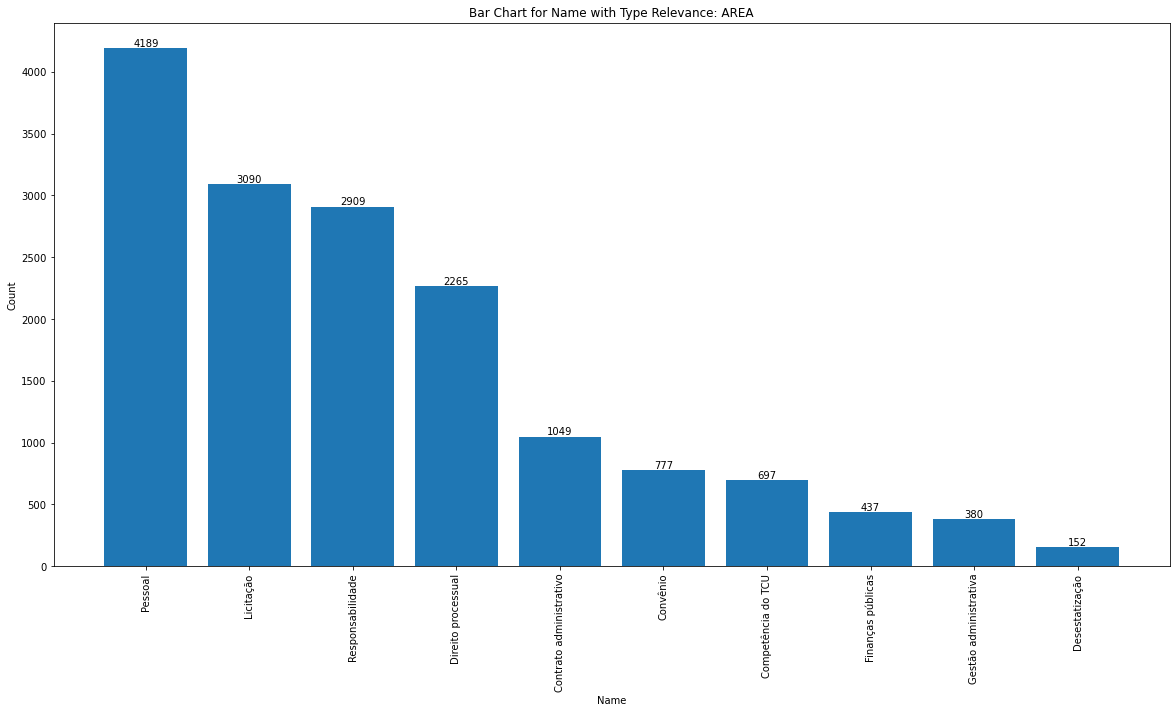

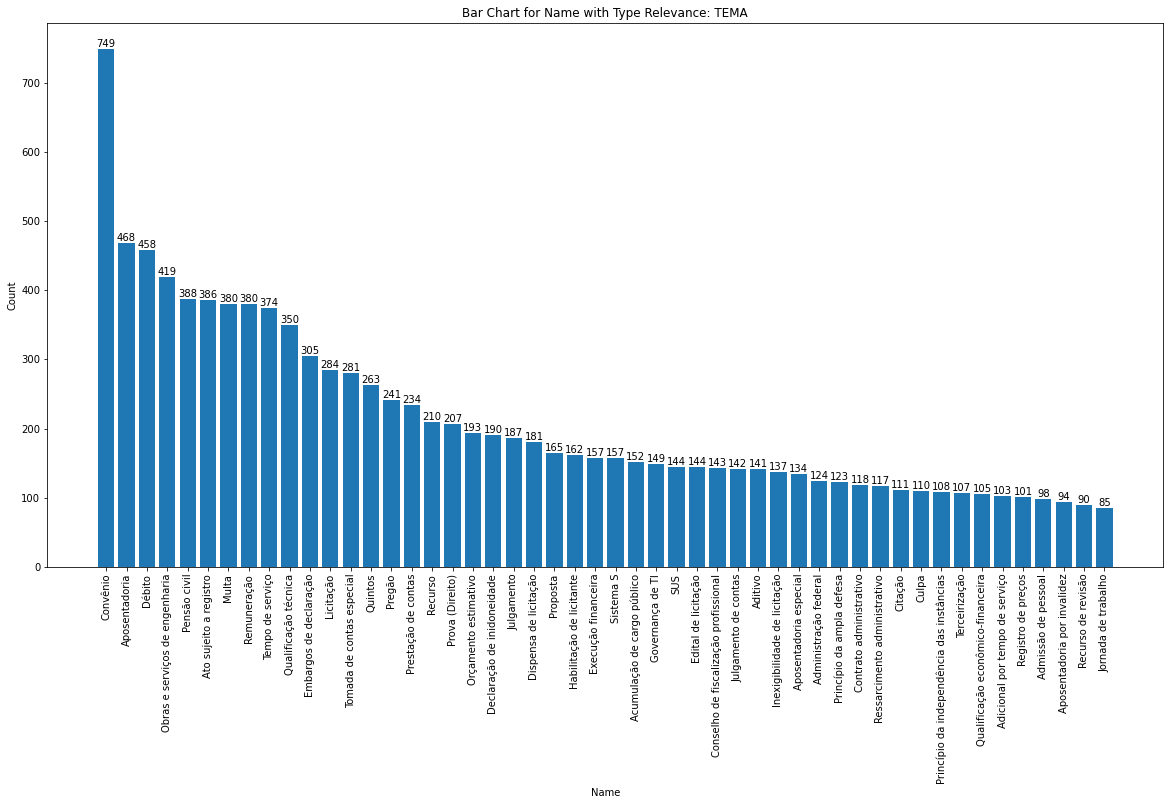

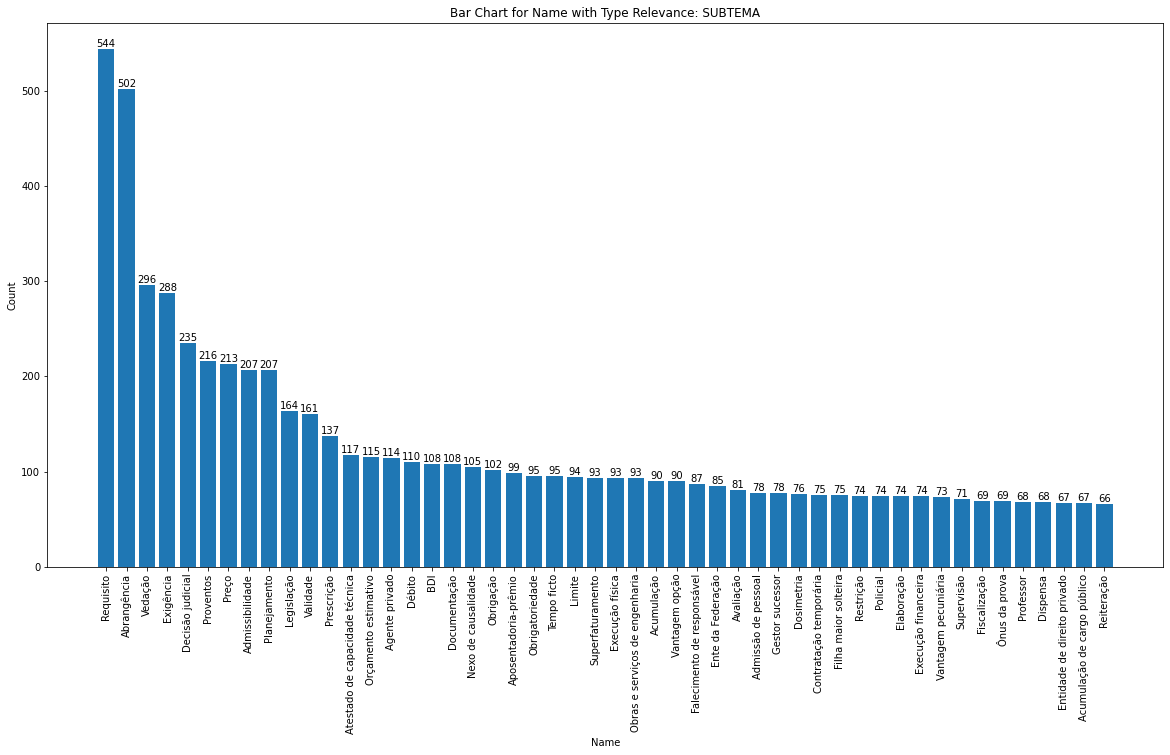

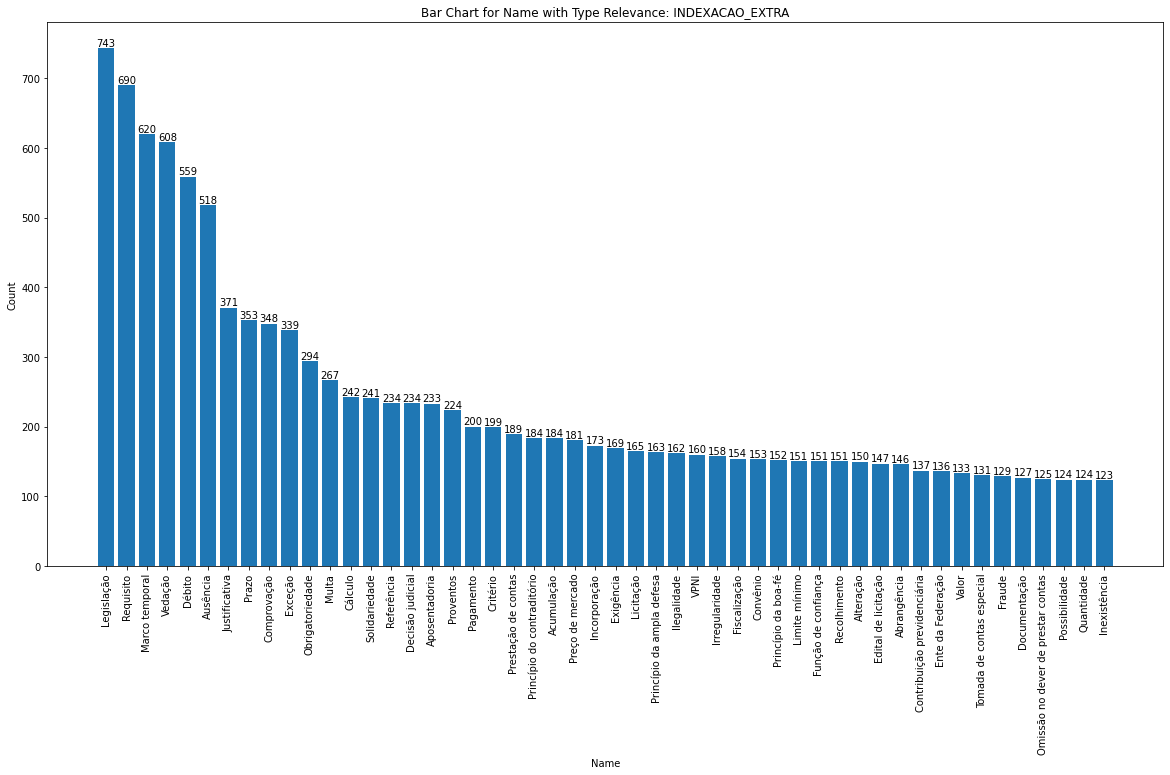

In [303]:
import matplotlib.pyplot as plt

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 50

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df = df[(df['TYPE_RELEVANCE'] == property) & (df['RELEVANCE']==1) ]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df['NAME'].value_counts().head(top_k)
    plt.figure(figsize=(20, 10))
    
    # Create the bar chart
    bars = plt.bar(name_counts.index, name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Rotate the x-axis labels for better visibility if needed
    plt.xticks(rotation=90)
    
    # Print the number on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Display the chart
    plt.show()


In [33]:
from tqdm import tqdm

Independente da categoria

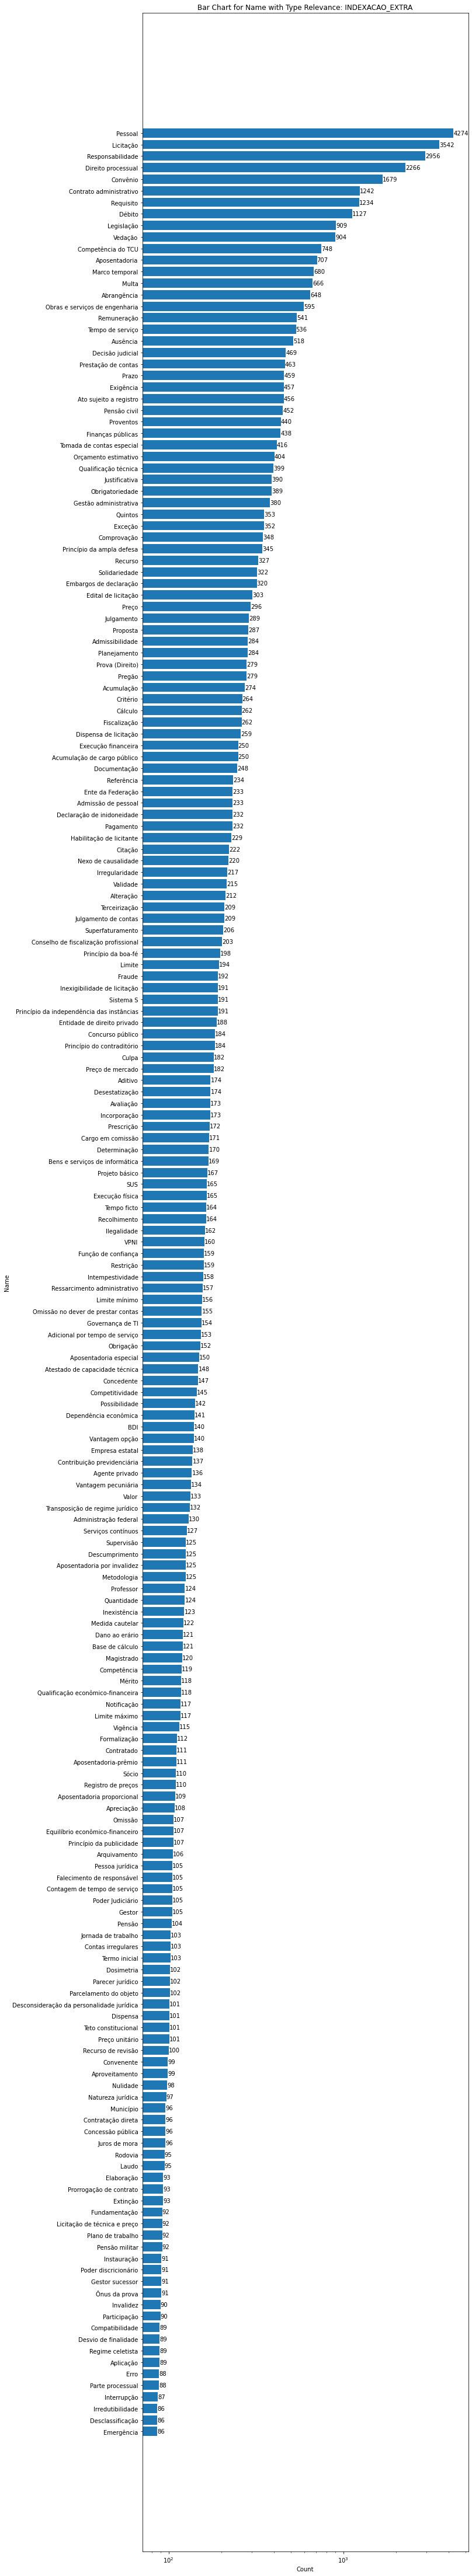

In [305]:

# Iterate over each property value in list_property
top_k = 200
plt.figure(figsize=(10, 80))  # Adjust the figure size as needed

# Filter the DataFrame for the given property value in TYPE_RELEVANCE
filtered_df = df[(df['RELEVANCE'] == 1)]

# Group by "name" and count the occurrences
name_counts = filtered_df['NAME'].value_counts().head(top_k)

# Sort the name_counts in descending order
name_counts = name_counts.sort_values(ascending=False)

# Reverse the order of values and labels
name_counts = name_counts.iloc[::-1]

# Create the horizontal bar chart

bars = plt.barh(np.arange(len(name_counts)), name_counts.values)

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Name')
plt.title(f'Bar Chart for Name with Type Relevance: {property}')

# Set the y-axis ticks and labels
plt.yticks(np.arange(len(name_counts)), name_counts.index)

# Set the scale of the x-axis to log base 10
plt.xscale('log')

# Print the number on the right side of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), ha='left', va='center')

# Display the chart
plt.show()


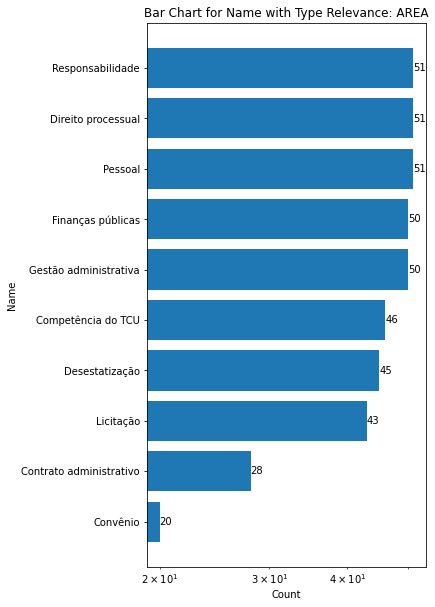

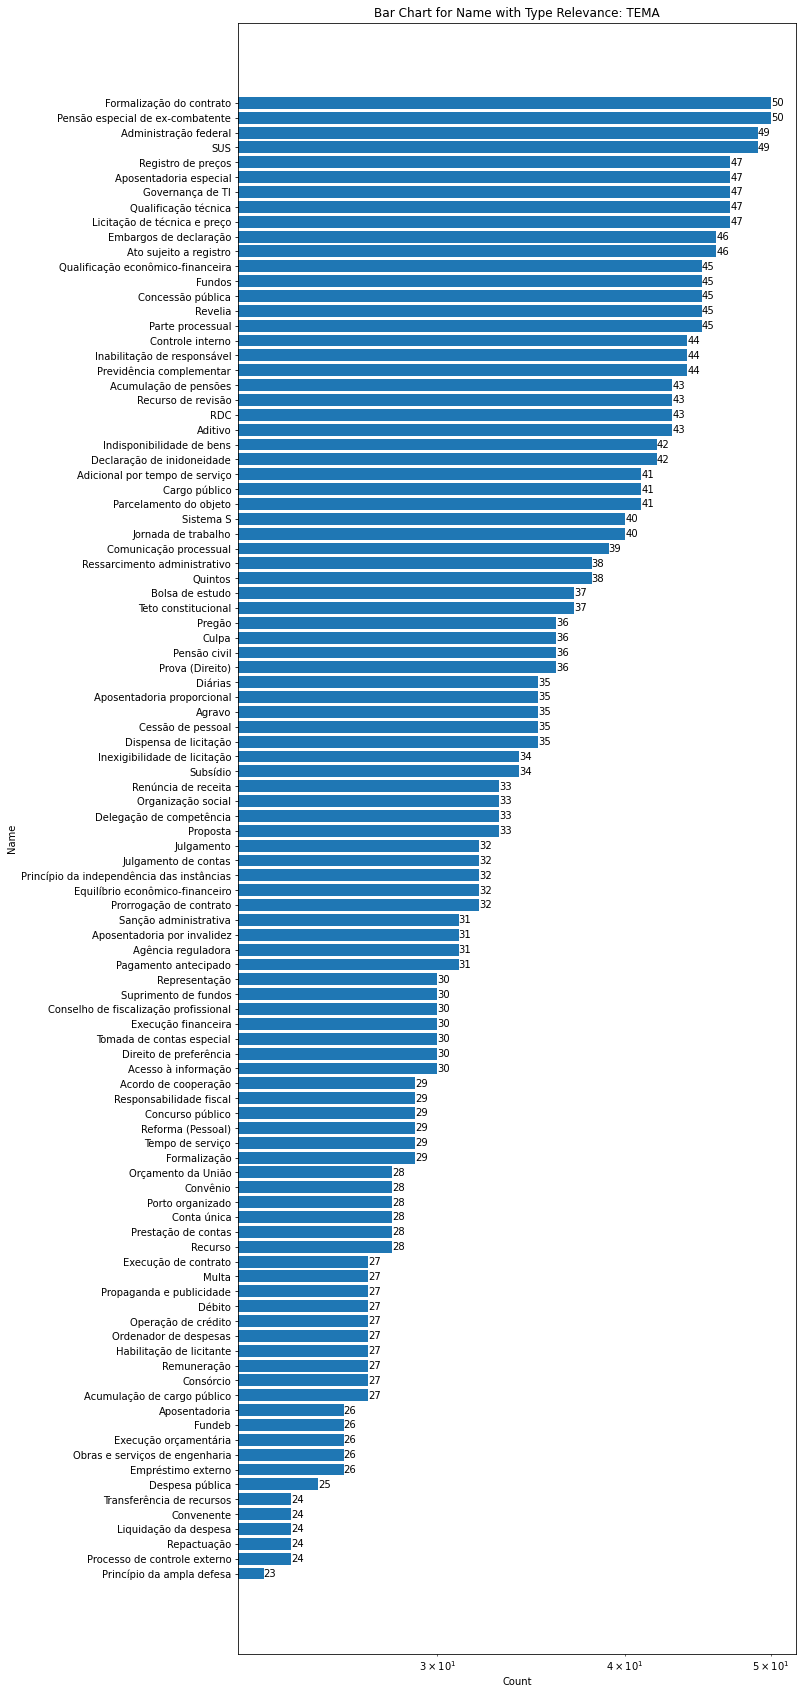

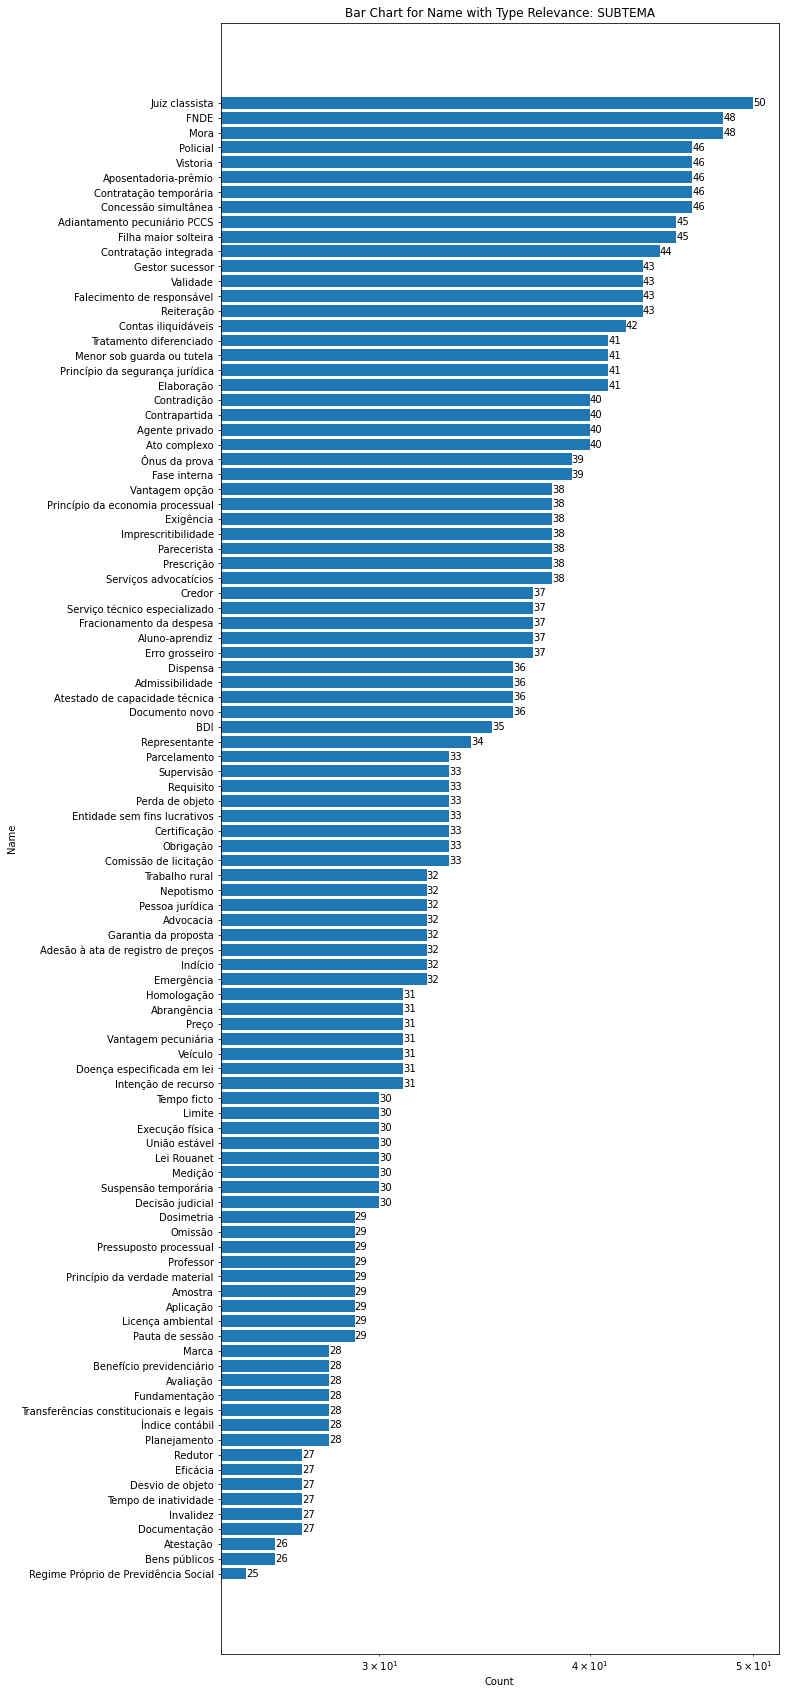

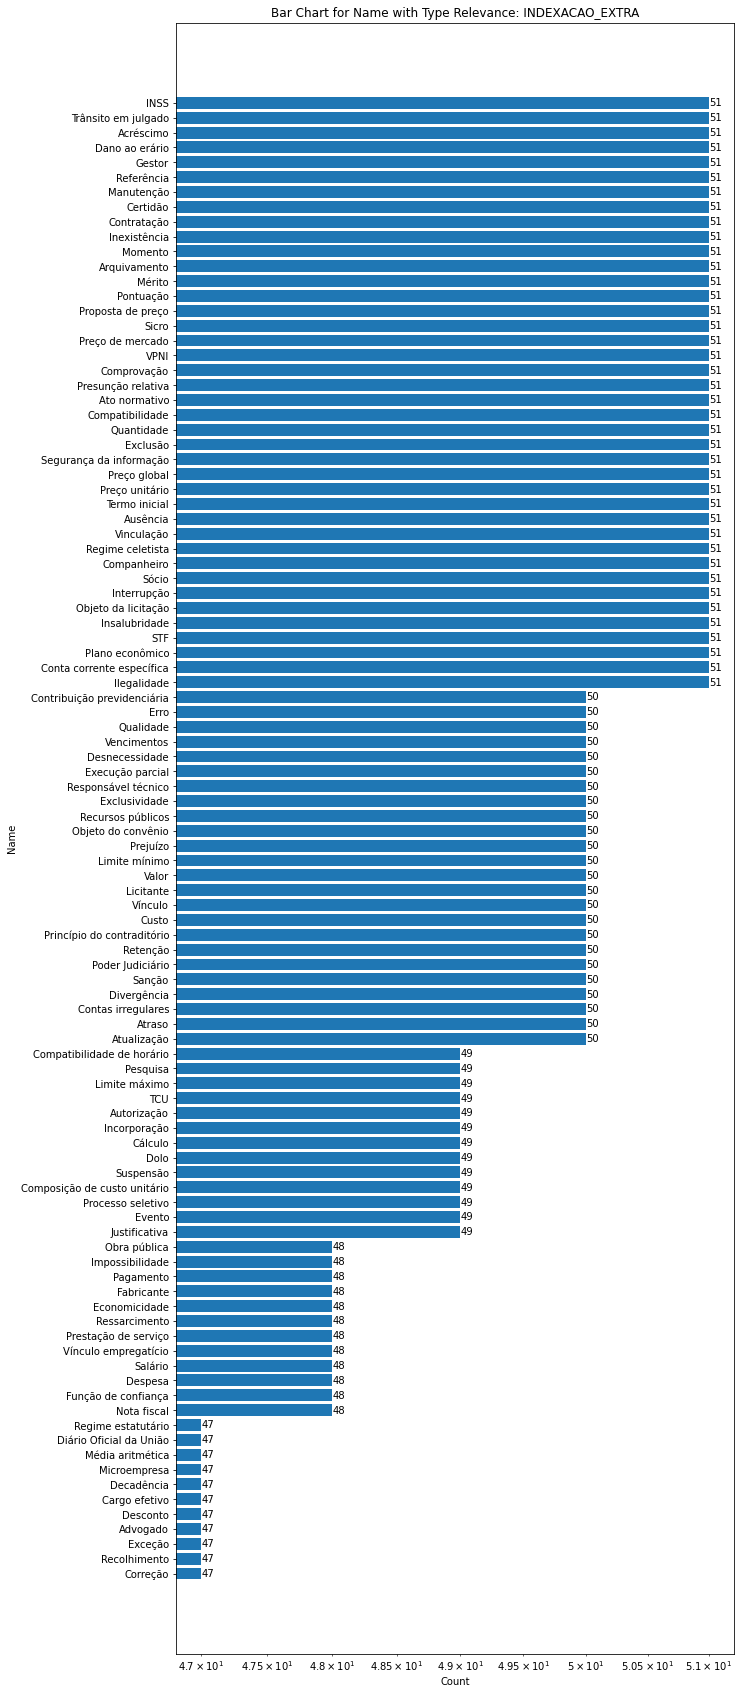

In [325]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
        plt.figure(figsize=(5, 10))  # Adjust the figure size as needed
    else:
        top_k = 100
        plt.figure(figsize=(10, 30))  # Adjust the figure size as needed

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df = df[(df['TYPE_RELEVANCE'] == property) & (df['RELEVANCE'] == 1)]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df['NAME'].value_counts().head(top_k)
    
    # Sort the name_counts in descending order
    name_counts = name_counts.sort_values(ascending=False)
    
    # Reverse the order of values and labels
    name_counts = name_counts.iloc[::-1]
    
    # Create the horizontal bar chart

    bars = plt.barh(np.arange(len(name_counts)), name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the y-axis ticks and labels
    plt.yticks(np.arange(len(name_counts)), name_counts.index)
    
    # Set the scale of the x-axis to log base 10
    plt.xscale('log')
    
    # Print the number on the right side of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), ha='left', va='center')
    
    # Display the chart
    plt.show()


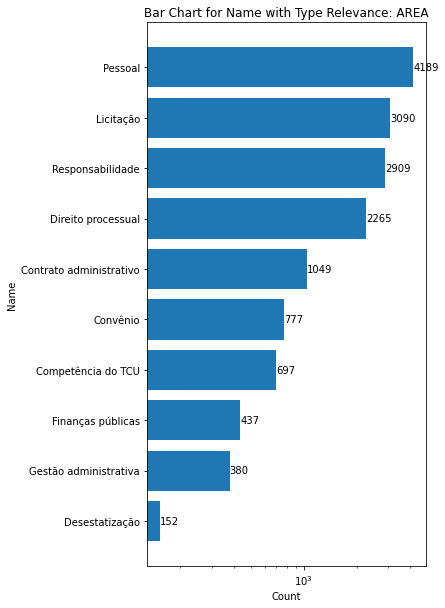

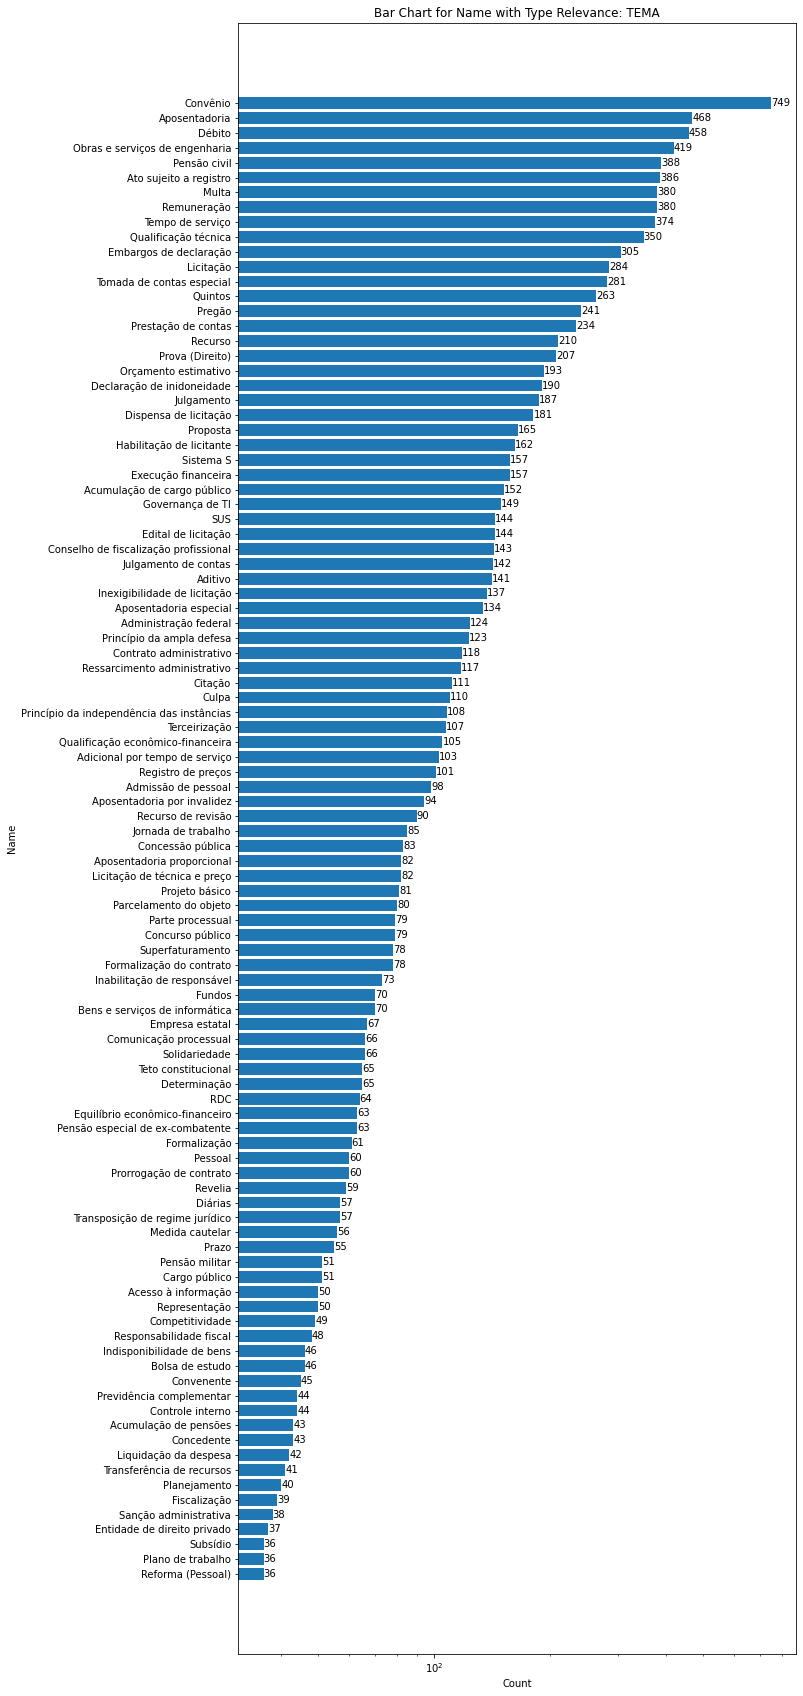

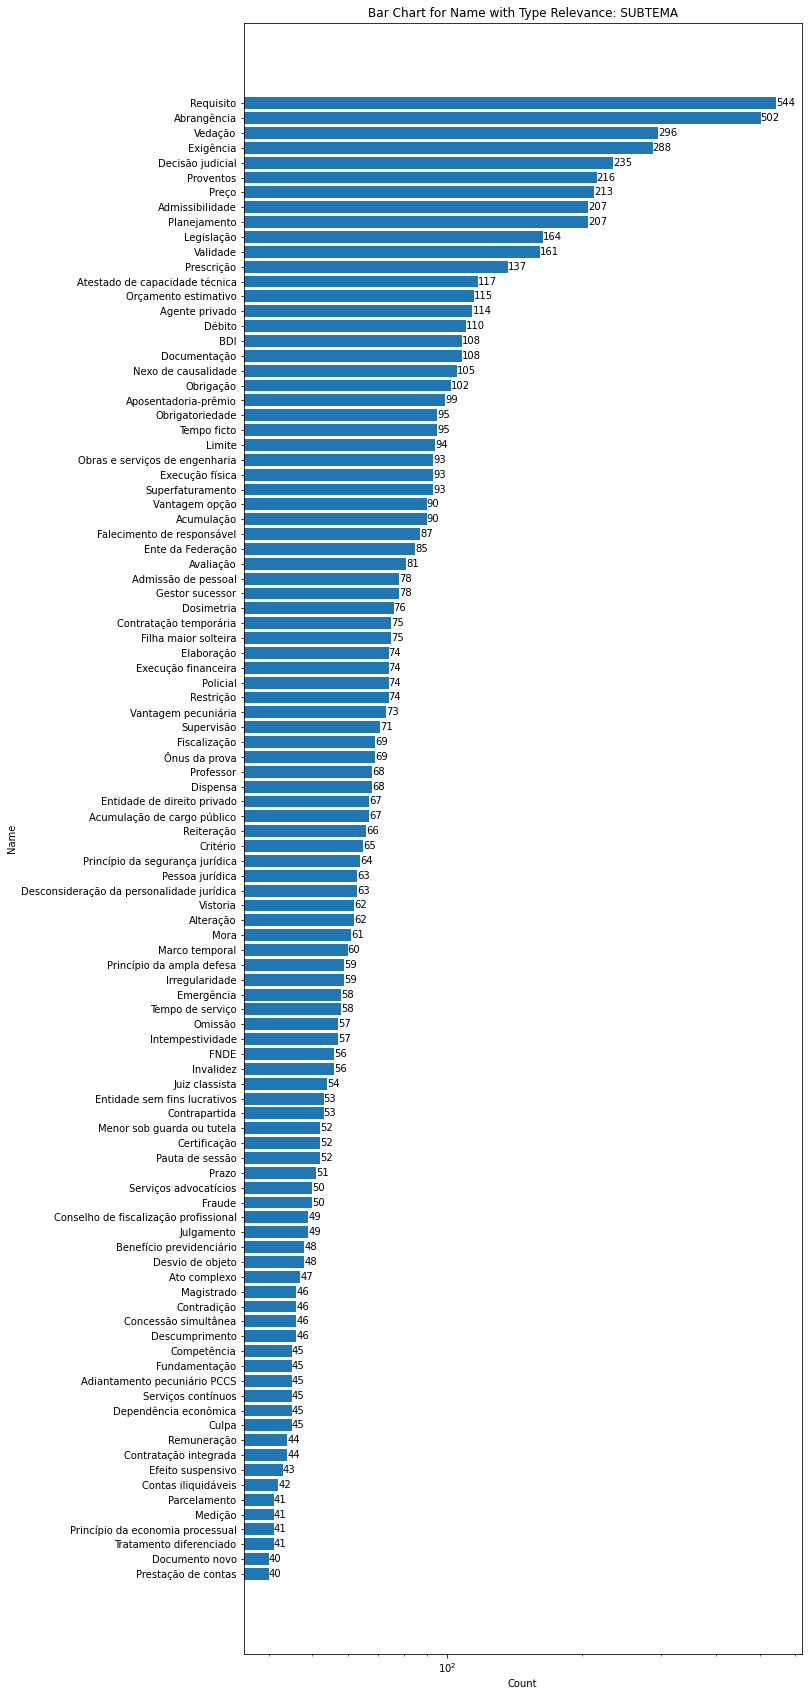

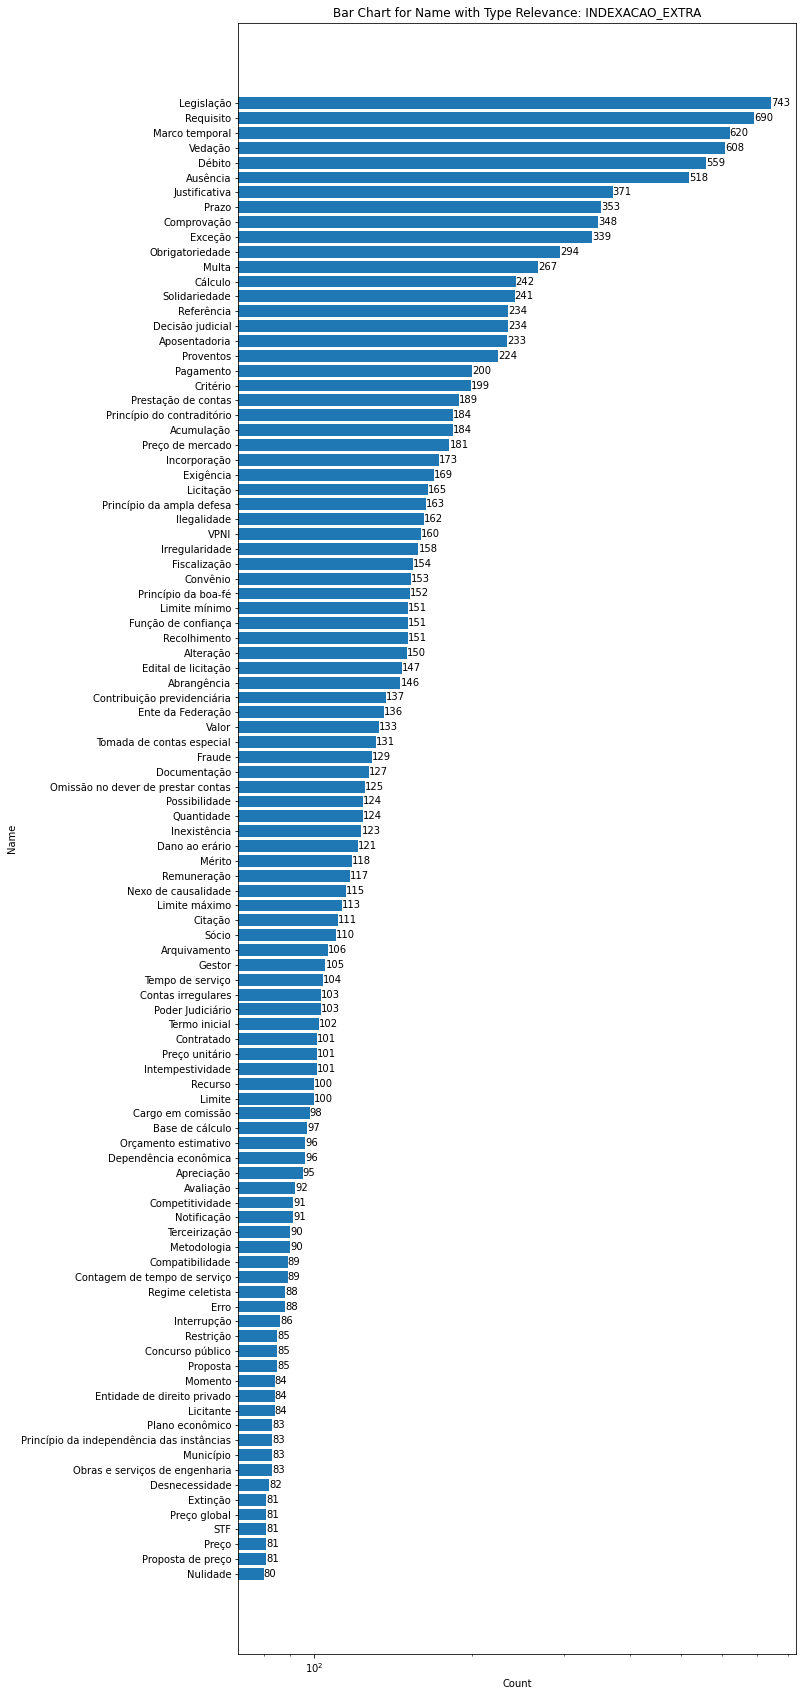

In [306]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
        plt.figure(figsize=(5, 10))  # Adjust the figure size as needed
    else:
        top_k = 100
        plt.figure(figsize=(10, 30))  # Adjust the figure size as needed

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df = df[(df['TYPE_RELEVANCE'] == property) & (df['RELEVANCE'] == 1)]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df['NAME'].value_counts().head(top_k)
    
    # Sort the name_counts in descending order
    name_counts = name_counts.sort_values(ascending=False)
    
    # Reverse the order of values and labels
    name_counts = name_counts.iloc[::-1]
    
    # Create the horizontal bar chart

    bars = plt.barh(np.arange(len(name_counts)), name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the y-axis ticks and labels
    plt.yticks(np.arange(len(name_counts)), name_counts.index)
    
    # Set the scale of the x-axis to log base 10
    plt.xscale('log')
    
    # Print the number on the right side of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), ha='left', va='center')
    
    # Display the chart
    plt.show()


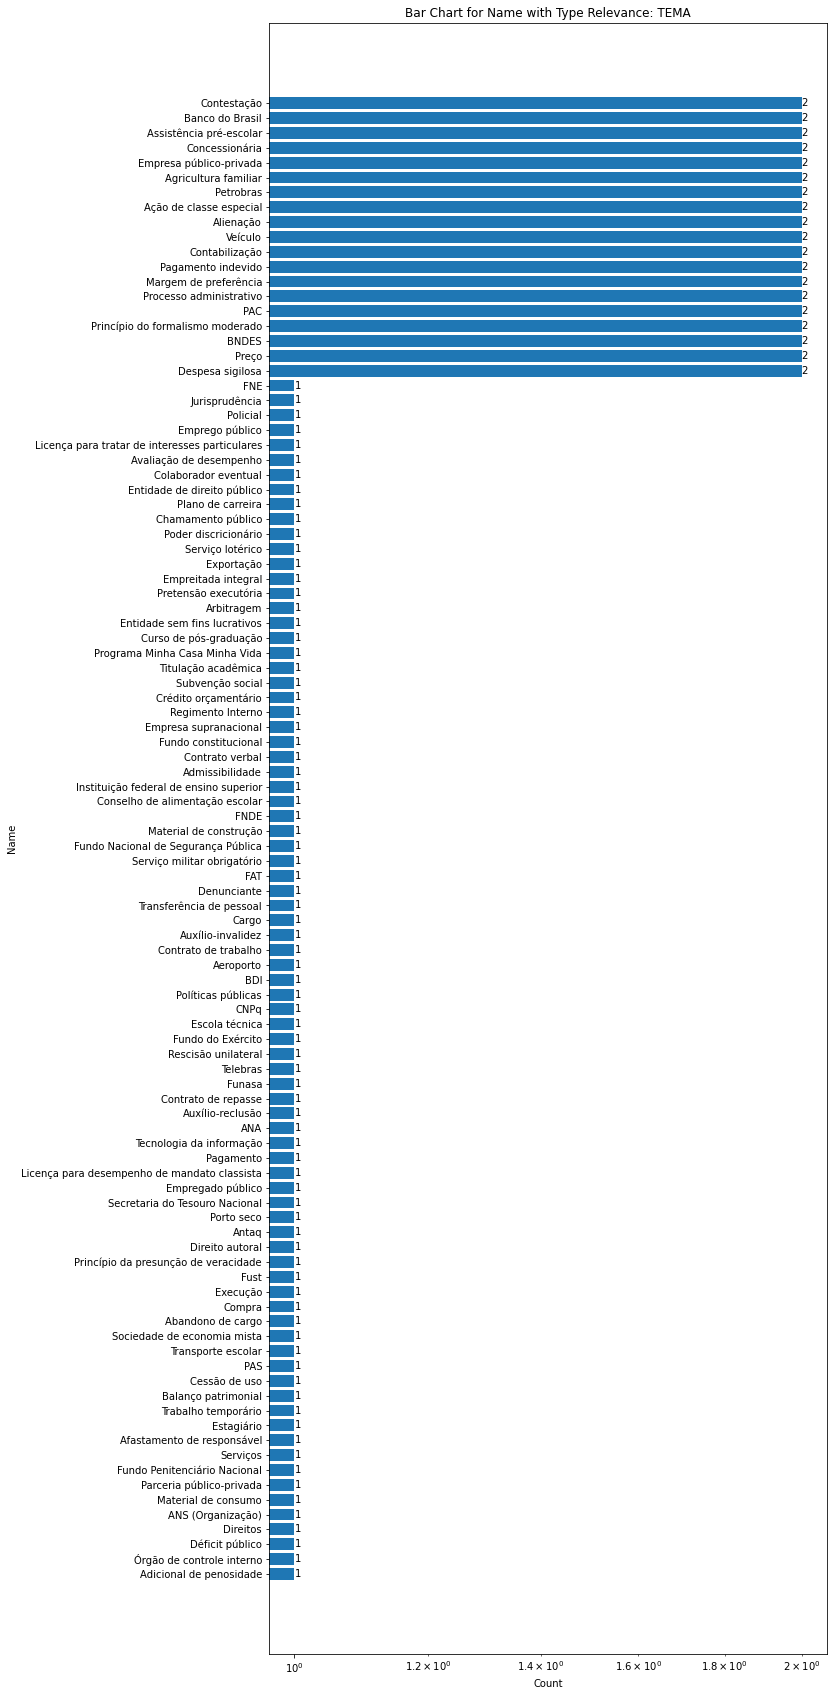

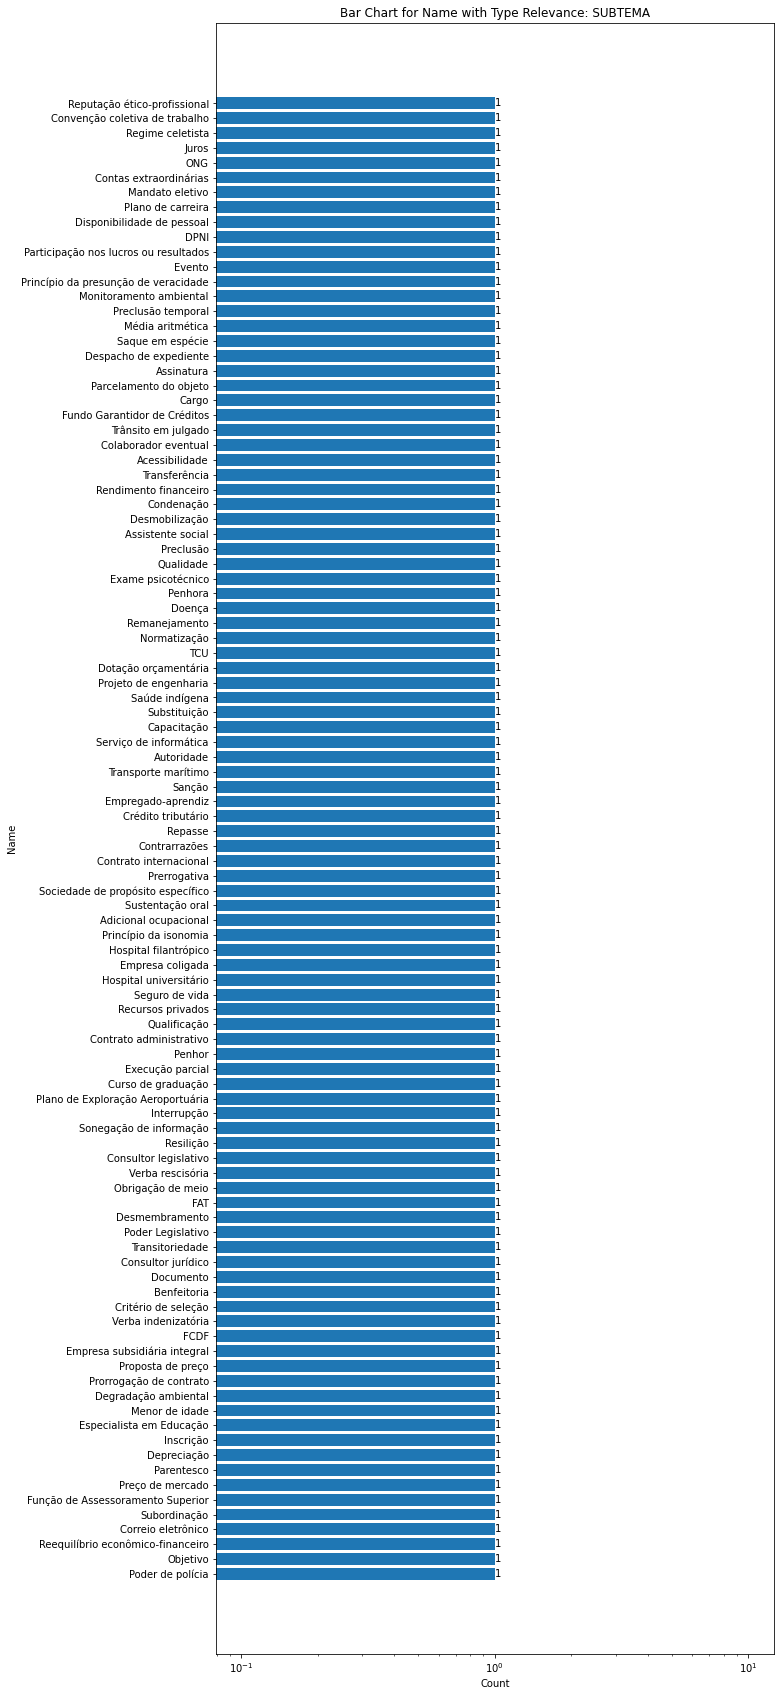

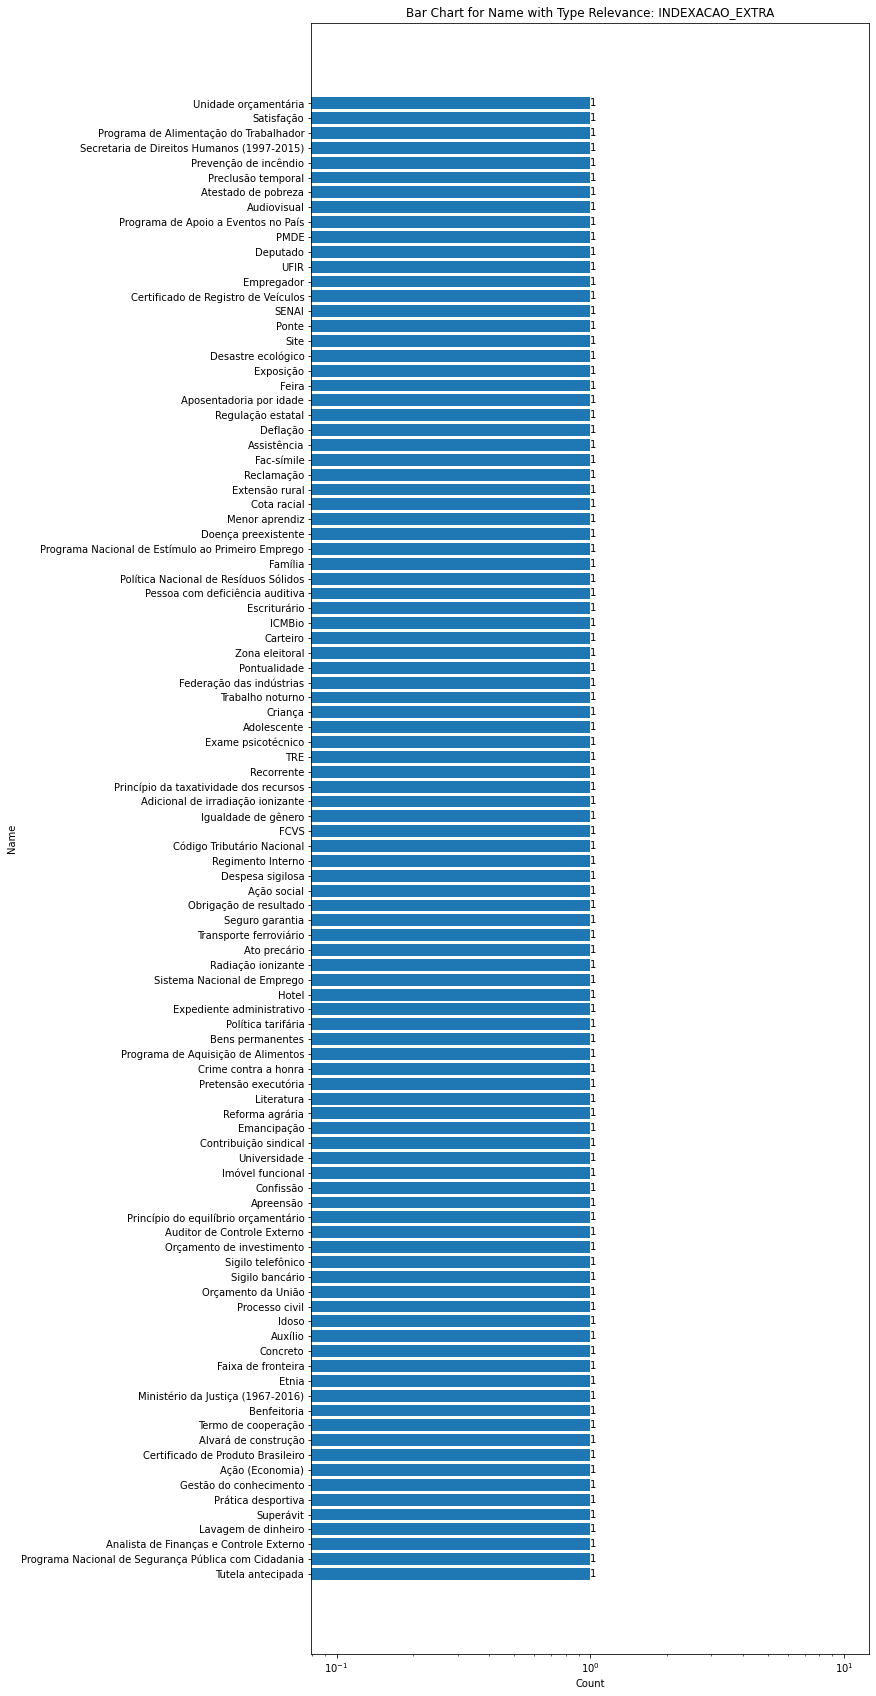

In [310]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        continue
    top_k = 100
    plt.figure(figsize=(10, 30))  # Adjust the figure size as needed

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df = df[(df['TYPE_RELEVANCE'] == property) & (df['RELEVANCE'] == 1)]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df['NAME'].value_counts().tail(top_k)
    
    # Sort the name_counts in descending order
    name_counts = name_counts.sort_values(ascending=False)
    
    # Reverse the order of values and labels
    name_counts = name_counts.iloc[::-1]
    
    # Create the horizontal bar chart

    bars = plt.barh(np.arange(len(name_counts)), name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the y-axis ticks and labels
    plt.yticks(np.arange(len(name_counts)), name_counts.index)
    
    # Set the scale of the x-axis to log base 10
    plt.xscale('log')
    
    # Print the number on the right side of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), ha='left', va='center')
    
    # Display the chart
    plt.show()


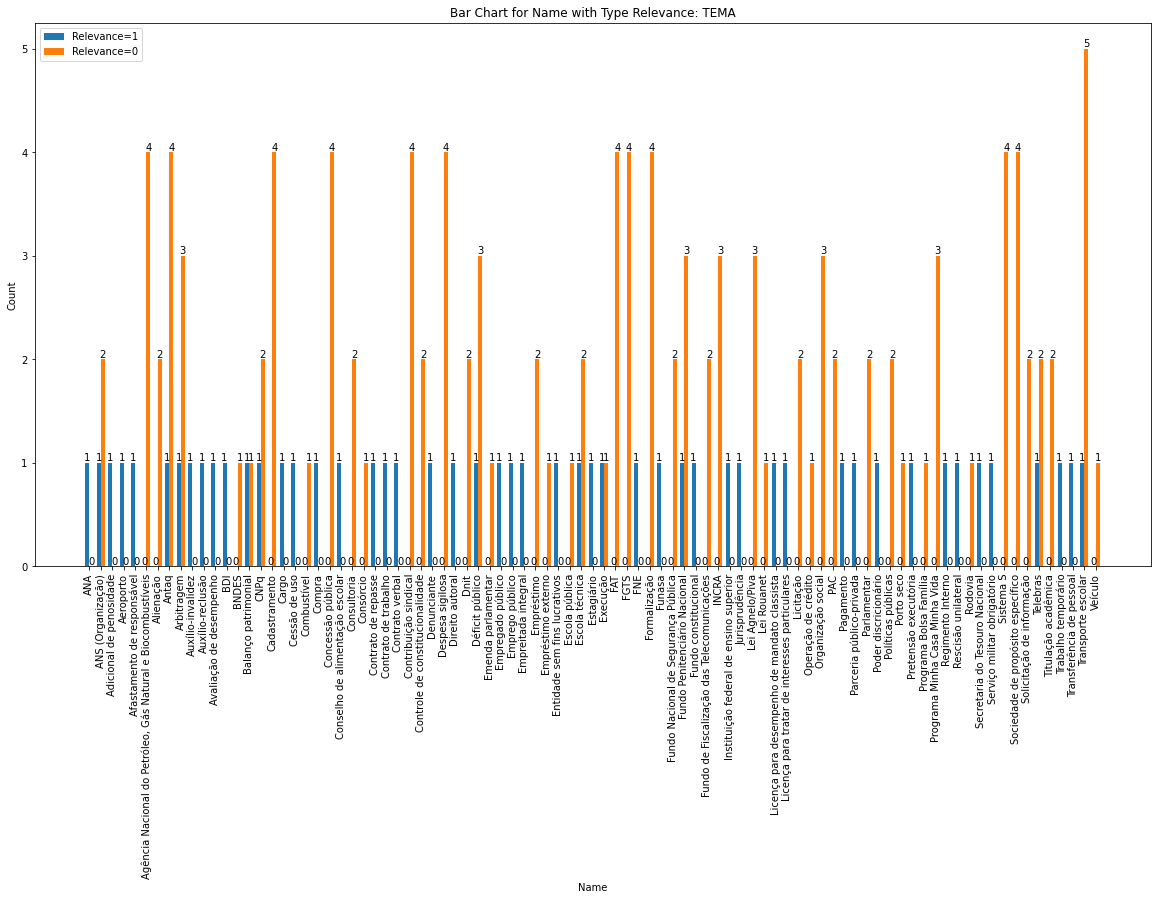

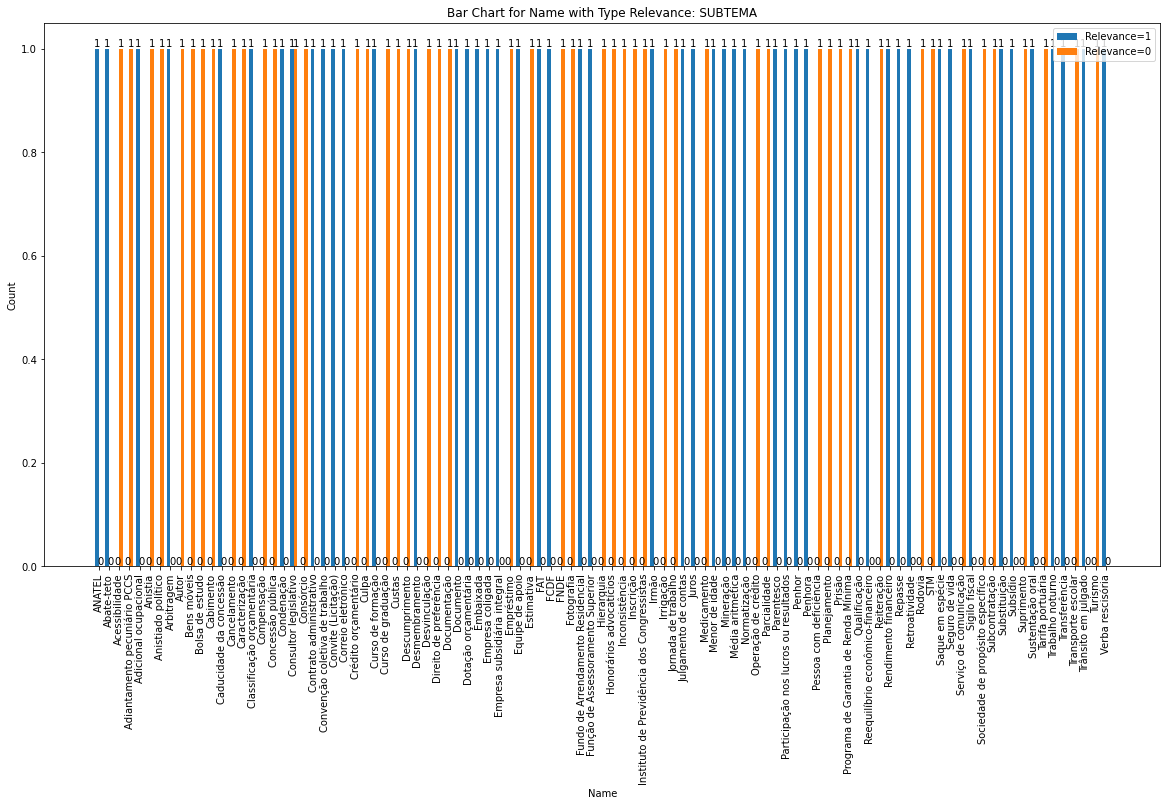

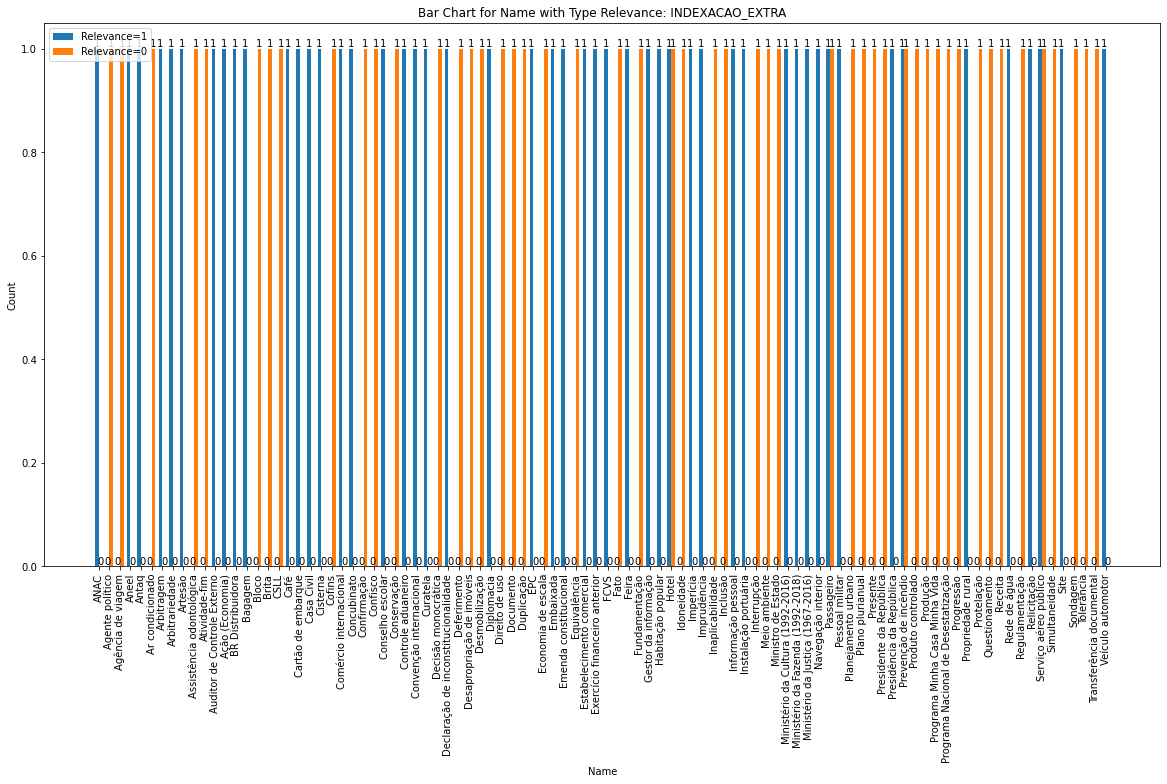

In [307]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        continue
    top_k = 50

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==1
    filtered_df_balanced_relevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 1)]
    
    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==0
    filtered_df_balanced_irrelevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 0)]
    
    # Get the top_k names with the highest counts in the relevant dataframe
    top_relevant_names = filtered_df_balanced_relevant['NAME'].value_counts().tail(top_k)
    
    # Get the top_k names with the highest counts in the irrelevant dataframe
    top_irrelevant_names = filtered_df_balanced_irrelevant['NAME'].value_counts().tail(top_k)
    
    # Combine the unique names from both dataframes
    unique_names = np.union1d(top_relevant_names.index, top_irrelevant_names.index)
    
    # Calculate the count of each name in the relevant and irrelevant dataframes
    relevant_counts = top_relevant_names.reindex(unique_names, fill_value=0)
    irrelevant_counts = top_irrelevant_names.reindex(unique_names, fill_value=0)
    
    # Set the width for each bar
    bar_width = 0.35
    
    # Create the x-axis positions for the bars
    x = np.arange(len(unique_names))
    
    # Create the bar chart
    plt.figure(figsize=(20, 10))
    bars_relevant = plt.bar(x, relevant_counts, width=bar_width, label='Relevance=1')
    bars_irrelevant = plt.bar(x + bar_width, irrelevant_counts, width=bar_width, label='Relevance=0')
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the x-axis ticks to the names
    plt.xticks(x + bar_width / 2, unique_names, rotation=90)
    
    # Print the number on top of each bar for relevance=1
    for bar in bars_relevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Print the number on top of each bar for relevance=0
    for bar in bars_irrelevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Add a legend
    plt.legend()
    
    # Display the chart
    plt.show()


# Generate "balanced" train data

Since training is not done by relevance type, we will limit it to a maximum of 100/50 occurrences as relevant and 100/50 occurrences as non-relevant

We will bring just one not relevant per relevant

We will use pipe bm25 to find not relevants

And firs executed sections above: Data load, Create reference to index and Pipe creation (only Bm25)

In [232]:
def describe_dict_count(parm_dict:dict, parm_dict_name:str):


    # Filter the dictionary to exclude zero values
    filtered_values = [value for value in parm_dict.values() if value > 0]

    if len(filtered_values) == 0:
        print(f"{parm_dict_name} is empty")
    else:

        # Calculate the number of records with value > 0
        values_greater_than_zero = len(filtered_values)

        # Calculate the sum of non-zero values
        total_sum = sum(filtered_values)

        # Calculate the mean value (excluding zeros)
        mean_value = np.mean(filtered_values)

        # Calculate the median value (excluding zeros)
        median_value = np.median(filtered_values)

        # Calculate the minimum value (excluding zeros)
        min_value = min(filtered_values)

        # Calculate the maximum value (excluding zeros)
        max_value = max(filtered_values)

        # Calculate the standard deviation (excluding zeros)
        std_value = np.std(filtered_values)

        # Print the results
        print(f"{parm_dict_name} - Number of records with value:", values_greater_than_zero, f"{100*values_greater_than_zero/len(parm_dict)}%" )
        print("   Total of data generated:", total_sum)
        print("   (by doc_id) Mean ", round(mean_value,2), end="")
        print(" Median:",median_value, end="")
        print(" Min:",min_value, end="")
        print(" Max:",max_value, end="")
        print(" Std:",round(std_value,2))
        print("")
        

In [233]:
df_search_data.shape

(16045, 14)

In [234]:
print('total doc id', len(count_relevant_by_doc_id))

total doc id 2859


In [235]:
df_search_data.columns

Index(['index', 'ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE',
       'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT', 'RELEVANCE_DICT_TYPE'],
      dtype='object')

In [236]:
%%time
max_count_negative = 1
list_train_data = []
factor_more_records = 5
limit_per_doc_id = 50

CPU times: user 4.96 ms, sys: 0 ns, total: 4.96 ms
Wall time: 5.06 ms


lim 100

        100%|██████████| 16045/16045 [09:11<00:00, 29.12it/s]CPU times: user 1min 19s, sys: 1.73 s, total: 1min 21s
        Wall time: 9min 11s

In [237]:
%%time
max_count_negative = 1
list_train_data = []
factor_more_records = 5
limit_per_doc_id = 50
count_discarded_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_discarded_not_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_not_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
sorted_df_search_data = df_search_data.sort_values(by='ID', ascending=False)
for cnt_row, (ndx, row_query) in tqdm(enumerate(sorted_df_search_data.iterrows()), mininterval=10, total=sorted_df_search_data.shape[0]):
    # print(f"cnt {cnt} query_id {row_query['ID']} ")
    set_not_relevant = set()
    list_not_in_docid = list(row_query['RELEVANCE_DICT'].keys())
    for type_relevance in ['AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA']:
        if type_relevance in row_query['RELEVANCE_DICT_TYPE']: # INDEXACAO_EXTRA pode não existir
            for cnt_doc_in_type, doc_id in enumerate(row_query['RELEVANCE_DICT_TYPE'][type_relevance]):
                if count_relevant_by_doc_id[doc_id] > limit_per_doc_id:
                    count_discarded_relevant_by_doc_id[doc_id] += 1
                else:
                    count_relevant_by_doc_id[doc_id] += 1
                    relevant_data = (row_query['ID'], doc_id, 1, type_relevance)
                    # print(f"     {relevant_data}")
                    list_train_data.append(relevant_data)
                    # Encontra primeiro encontrado para não relevante    
                    if type_relevance == 'AREA':
                        type_field_count = "count_index_area"
                    elif type_relevance == 'TEMA':
                        type_field_count = "count_index_theme"
                    elif type_relevance == 'SUBTEMA':
                        type_field_count = "count_index_subtheme"
                    elif type_relevance == 'INDEXACAO_EXTRA':
                        type_field_count = "count_index_extra"
                    else:
                        raise Exception(f"type_relevance {type_relevance} not expected!")     
                    doc_returned = pipe.run(query=row_query['TEXT'], 
                                        params={"Retriever": {"top_k": max_count_negative*factor_more_records},
                                                "filters":{"$and": {type_field_count: {"$gte": 1},
                                                "$not": {"id": {"$in": list_not_in_docid}}
                                                }}})
                    if len(doc_returned['documents']) == 0:
                        raise Exception(f"Not found negative examples!")
                    count_negative = 0
                    for ndx, docto in enumerate(doc_returned['documents']):
                        if count_negative >= max_count_negative:
                            break   
                        if docto.meta['id'] not in set_not_relevant:
                            if count_not_relevant_by_doc_id[doc_id] > limit_per_doc_id:
                                count_discarded_not_relevant_by_doc_id[doc_id] += 1
                            else:
                                count_not_relevant_by_doc_id[doc_id] += 1                                
                                count_negative += 1
                                set_not_relevant.add(docto.meta['id'])
                                list_not_in_docid.append(docto.meta['id'])
                                not_relevant_data = (row_query['ID'], docto.meta['id'], 0, type_relevance)
                                # print(f"     {not_relevant_data}")                    
                                list_train_data.append(not_relevant_data)
                    if count_negative < max_count_negative:
                        print(f"Less negative {count_negative} than {max_count_negative} for query_id {row_query['ID']} in {type_relevance}")
    # if cnt_row > 10: break



100%|██████████| 16045/16045 [06:13<00:00, 42.99it/s]

CPU times: user 55.7 s, sys: 1.15 s, total: 56.8 s
Wall time: 6min 13s


In [238]:
describe_dict_count(count_relevant_by_doc_id, 'count_relevant_by_doc_id')
describe_dict_count(count_not_relevant_by_doc_id, 'count_not_relevant_by_doc_id')
describe_dict_count(count_discarded_relevant_by_doc_id, 'count_discarded_relevant_by_doc_id')
describe_dict_count(count_discarded_not_relevant_by_doc_id, 'count_discarded_not_relevant_by_doc_id')

count_relevant_by_doc_id - Number of records with value: 2859 100.0%
   Total of data generated: 43657
   (by doc_id) Mean  15.27 Median: 6.0 Min: 1 Max: 51 Std: 17.59

count_not_relevant_by_doc_id - Number of records with value: 2859 100.0%
   Total of data generated: 43657
   (by doc_id) Mean  15.27 Median: 6.0 Min: 1 Max: 51 Std: 17.59

count_discarded_relevant_by_doc_id - Number of records with value: 360 12.591815320041972%
   Total of data generated: 51135
   (by doc_id) Mean  142.04 Median: 42.0 Min: 1 Max: 4253 Std: 382.85

count_discarded_not_relevant_by_doc_id is empty


In [239]:
df = pd.DataFrame(list_train_data, columns= ['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE'])

In [240]:
df.shape
# bm25 (284376, 4)
# limite 100 (112512, 4)
# limite 50 (87314, 4)

(87314, 4)

In [241]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE
0,151655,775,1,AREA
1,151655,5095,0,AREA
2,151655,1943,1,TEMA
3,151655,1322,0,TEMA
4,151655,15694,1,SUBTEMA


## Agregate doc text

In [242]:
df_doc.shape

(13255, 28)

In [243]:
pipe_type

'bm25'

In [244]:
df_query.shape

(16045, 11)

merge with doc

In [245]:
df = df.merge(df_doc[['ID','TEXT']], how='left', left_on='DOC_ID', right_on='ID').drop('ID',axis=1)

In [246]:
df.rename(columns={'TEXT': 'DOC_TEXT'},inplace=True)

In [247]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT
0,151655,775,1,AREA,"O termo é ""Responsabilidade"".\nResponsabilidade tem definição: ""Qualidade de quem responde pelos..."
1,151655,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência do TCU tem definição: ""São as seguintes as competên..."
2,151655,1943,1,TEMA,"O termo é ""Agente público"".\nAgente público tem definição: ""Pessoa a quem o Estado delega podere..."
3,151655,1322,0,TEMA,"O termo é ""Receita pública"".\nReceita pública tem definição: ""Conjunto de recursos que o Estado ..."
4,151655,15694,1,SUBTEMA,"O termo é ""Hierarquia"".\nHierarquia tem definição: ""Ordem e subordinação dos poderes eclesiástic..."


In [248]:
df = df.merge(df_query[['ID','TEXT']], how='left', left_on='QUERY_ID', right_on='ID').drop('ID',axis=1)

In [249]:
df.rename(columns={'TEXT': 'QUERY_TEXT'},inplace=True)

In [250]:
df.shape

(87314, 6)

In [251]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

In [252]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT,QUERY_TEXT
0,151655,775,1,AREA,"O termo é ""Responsabilidade"".\nResponsabilidade tem definição: ""Qualidade de quem responde pelos...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
1,151655,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência do TCU tem definição: ""São as seguintes as competên...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
2,151655,1943,1,TEMA,"O termo é ""Agente público"".\nAgente público tem definição: ""Pessoa a quem o Estado delega podere...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
3,151655,1322,0,TEMA,"O termo é ""Receita pública"".\nReceita pública tem definição: ""Conjunto de recursos que o Estado ...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
4,151655,15694,1,SUBTEMA,"O termo é ""Hierarquia"".\nHierarquia tem definição: ""Ordem e subordinação dos poderes eclesiástic...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...


## Remove validation data

In [253]:
PATH_VALID_DATA = f"../data/train_juris_tcu_index/juris_tcu_index_validation_query_id.csv"

In [254]:
df_validation = pd.read_csv(PATH_VALID_DATA)

In [255]:
df_validation.shape

(100, 1)

In [256]:
df_validation.head(5)

,QUERY_ID
0,4273
1,36
2,1650
3,22806
4,49608


In [257]:
list_query_id_valid = df_validation['QUERY_ID'].to_list()

triplas: query + id_doc + ind_relevancia (1, se positivo,  e 0 se negativo)

In [258]:
df.shape

(87314, 6)

In [259]:
df = df[~df['QUERY_ID'].isin(list_query_id_valid)]


In [260]:
df.shape

(86804, 6)

In [261]:
path_thain =  f'../data/train_juris_tcu_index/train_data_juris_tcu_index_limit_50_per_doc.csv'

In [262]:
path_thain

'../data/train_juris_tcu_index/train_data_juris_tcu_index_limit_50_per_doc.csv'

In [263]:
df.to_csv(path_thain, sep=',', index=False)

# Evoluir

ideias:

        . pegar os não por sample 0 a 100
        . pegar inicialmente por tipo.
        . aumentando limite após cada execução
                tema: 50
                subtema: 50
                extra: 50
                aera: 50
        máximo 200 + e 200 -


We will bring just one not relevant per relevant

We will use pipe bm25 to find not relevants

And firs executed sections above: Data load, Create reference to index and Pipe creation (only Bm25)

In [54]:
import random

# Define a semente
seed = 123

# Define a semente para o gerador de números aleatórios
random.seed(seed)



In [ ]:
count_values_filtered = [value for value in parm_dict.values() if value > 0]
len(count_values_filtered)
min(count_values_filtered)

In [164]:
def describe_dict_count(parm_dict:dict, parm_dict_name:str):


    # Filter the dictionary to exclude zero values
    filtered_values = [value for value in parm_dict.values() if value > 0]

    if len(filtered_values) == 0:
        print(f"{parm_dict_name} is empty")
    else:

        # Calculate the number of records with value > 0
        values_greater_than_zero = len(filtered_values)

        # Calculate the sum of non-zero values
        total_sum = sum(filtered_values)

        # Calculate the mean value (excluding zeros)
        mean_value = np.mean(filtered_values)

        # Calculate the median value (excluding zeros)
        median_value = np.median(filtered_values)

        # Calculate the minimum value (excluding zeros)
        min_value = min(filtered_values)

        # Calculate the maximum value (excluding zeros)
        max_value = max(filtered_values)

        # Calculate the standard deviation (excluding zeros)
        std_value = np.std(filtered_values)

        # Print the results
        print(f"{parm_dict_name} - Number of records with value:", values_greater_than_zero, f"{100*values_greater_than_zero/len(parm_dict)}%" )
        print("   Total of values:", total_sum)
        print("   (by doc_id) Mean ", round(mean_value,2), end="")
        print(" Median:",median_value, end="")
        print(" Min:",min_value, end="")
        print(" Max:",max_value, end="")
        print(" Std:",round(std_value,2))
        print("")
        

In [43]:
df_search_data.shape

(16045, 14)

In [45]:
df_search_data.columns

Index(['index', 'ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE',
       'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT', 'RELEVANCE_DICT_TYPE'],
      dtype='object')

lim 100

        100%|██████████| 16045/16045 [09:11<00:00, 29.12it/s]CPU times: user 1min 19s, sys: 1.73 s, total: 1min 21s
        Wall time: 9min 11s

In [223]:
def generate_train_data_per_relevance_type(parm_type_relevance:str,
                    parm_total_read:int, 
                    parm_if_limit_search_on_type:bool,
                    parm_limit_relevant_per_doc_id:int,
                    parm_max_count_negative:int):
    global count_discarded_relevant_by_doc_id, count_discarded_not_relevant_by_doc_id
    global count_relevant_by_doc_id, count_not_relevant_by_doc_id
    global type_relevance_map

    limit_not_relevant_per_doc_id = parm_limit_relevant_per_doc_id * parm_max_count_negative

    list_train_data = []
    type_field_count = type_relevance_map.get(parm_type_relevance)
    if type_field_count is None:
        raise Exception(f"type_relevance {parm_type_relevance} not expected!")

    if parm_if_limit_search_on_type:
        label_source_type_search = parm_type_relevance
        search_criteria_field_count = type_field_count
    else:
        label_source_type_search = f"relevant:{parm_type_relevance}, not relevant:TOTAL"
        search_criteria_field_count = "count_index_total"



    print(f"Parameters:")
    print(f"  parm_type_relevance: {parm_type_relevance}")
    print(f"  parm_total_read: {parm_total_read}")
    print(f"  parm_if_limit_search_on_type: {parm_if_limit_search_on_type}")
    print(f"  parm_max_count_negative: {parm_max_count_negative}")    
    print(f"  parm_limit_relevant_per_doc_id: {parm_limit_relevant_per_doc_id}")
    print(f"  limit_not_relevant_per_doc_id (calculated): {limit_not_relevant_per_doc_id}")
    print(f"  label_source_type_search (calculated): {label_source_type_search}")
    print(f"  search_criteria_field_count (calculated): {search_criteria_field_count}")
    
    sorted_df_search_data = df_search_data.sort_values(by='ID', ascending=False)
    count_limit_negative_broken = 0
    for cnt_row, (ndx_row, row_query) in tqdm(enumerate(sorted_df_search_data.iterrows()), mininterval=10, total=sorted_df_search_data.shape[0]):
        # Resto do código...
        # print(f"cnt {cnt} query_id {row_query['ID']} ")
        set_not_relevant = set()
        list_not_in_docid = list(row_query['RELEVANCE_DICT'].keys())
        if parm_type_relevance in row_query['RELEVANCE_DICT_TYPE']: # INDEXACAO_EXTRA pode não existir
            for cnt_doc_in_type, doc_id in enumerate(row_query['RELEVANCE_DICT_TYPE'][parm_type_relevance]):
                if count_relevant_by_doc_id[doc_id] > parm_limit_relevant_per_doc_id:
                    count_discarded_relevant_by_doc_id[doc_id] += 1
                else:
                    count_relevant_by_doc_id[doc_id] += 1
                    # busca score do termo
 
                    doc_returned = pipe.run(query=row_query['TEXT'], 
                                        params={"Retriever": {"top_k": 2},
                                                "filters":{"id": doc_id}})
                    if len(doc_returned['documents']) > 1:
                        raise Exception(f"Found more then one positive example {doc_id}")
                    if len(doc_returned['documents']) == 0:
                        # print(f"Pipe used did not found positive example {parm_type_relevance} {doc_id} of query {row_query['ID']}; relevant data with score=0 relevance assumed with query: {row_query['TEXT']}")
                        score = 0
                    else: 
                        score = round(doc_returned['documents'][0].score,3)
                    relevant_data = (row_query['ID'], doc_id, 1,  score, parm_type_relevance)
                    # print(f"     {relevant_data}")
                    list_train_data.append(relevant_data)

                    # Encontra primeiro encontrado para não relevante    
                    doc_returned = pipe.run( query=row_query['TEXT'],
                                                params={"Retriever": {"top_k": parm_total_read},
                                                    "filters":{"$and": {search_criteria_field_count: {"$gte": 1},
                                                    "$not": {"id": {"$in": list_not_in_docid}}
                                                    }}})

                    count_doc_returned = len(doc_returned['documents'])
                    if count_doc_returned == 0:
                        raise Exception(f"Not found negative examples!")



                    # Embaralhar os índices
                    random_index = list(range(len(doc_returned['documents'])))
                    random.shuffle(random_index)             

                    count_discarded_not_relevant = 0
                    count_negative = 0
                    for ndx in random_index:
                        docto = doc_returned['documents'][ndx]
                        if count_negative >= parm_max_count_negative:
                            break   
                        if docto.meta['id'] in set_not_relevant:
                            raise Exception(f"Negative example not expected: review list_not_in_docid formation!")
                        else:
                            if (count_not_relevant_by_doc_id[docto.meta['id']] > limit_not_relevant_per_doc_id) \
                                and (count_limit_negative_broken == 0):
                                count_discarded_not_relevant_by_doc_id[docto.meta['id']] += 1
                                count_discarded_not_relevant += 1
                            else:
                                count_not_relevant_by_doc_id[docto.meta['id']] += 1                                
                                count_negative += 1
                                set_not_relevant.add(docto.meta['id'])
                                list_not_in_docid.append(docto.meta['id'])
                                not_relevant_data = (row_query['ID'], docto.meta['id'], 0, 
                                                    round(docto.score,3), label_source_type_search)
                                # print(f"     {not_relevant_data}")                    
                                list_train_data.append(not_relevant_data)

                    if count_negative < parm_max_count_negative:
                        count_limit_negative_broken += 1
                        print(f"Less negative {count_negative} than {parm_max_count_negative} for query_id {row_query['ID']} in {parm_type_relevance}: discarded {count_discarded_not_relevant} in {count_doc_returned} returned. Size list_not_in_docid {len(list_not_in_docid)} antes: count_limit_negative_broken {count_limit_negative_broken}" )     
                        print(f"Next will generate negative with more than limit {limit_not_relevant_per_doc_id} ")

                        # complement current generation
                        for ndx in random_index:
                            docto = doc_returned['documents'][ndx]
                            if count_negative >= parm_max_count_negative:
                                break   
                            if docto.meta['id'] in set_not_relevant:
                                raise Exception(f"Negative example not expected: review list_not_in_docid formation!")
                            else:
                                if (count_not_relevant_by_doc_id[docto.meta['id']] > limit_not_relevant_per_doc_id) \
                                    and (count_limit_negative_broken == 0):
                                    count_discarded_not_relevant_by_doc_id[docto.meta['id']] += 1
                                    count_discarded_not_relevant += 1
                                else:
                                    count_not_relevant_by_doc_id[docto.meta['id']] += 1                                
                                    count_negative += 1
                                    set_not_relevant.add(docto.meta['id'])
                                    list_not_in_docid.append(docto.meta['id'])
                                    not_relevant_data = (row_query['ID'], docto.meta['id'], 0, 
                                                        round(docto.score,3), label_source_type_search)
                                    # print(f"     {not_relevant_data}")                    
                                    list_train_data.append(not_relevant_data)



        # if cnt_row > 2: break
    return list_train_data


In [224]:
type_relevance_map = {
    'AREA': 'count_index_area',
    'TEMA': 'count_index_theme',
    'SUBTEMA': 'count_index_subtheme',
    'INDEXACAO_EXTRA': 'count_index_extra'
}


In [225]:
%%time
count_discarded_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_discarded_not_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}
count_not_relevant_by_doc_id = {k: 0 for dict_rel in df_search_data['RELEVANCE_DICT'] for k in dict_rel.keys()}

limit_total_search_for_non_relevant = 1000
limit_relevant_per_doc_id = 50
max_count_negative = 5
list_train_data = []
if_limit_search_on_type = False

for cnt, type_relevance in enumerate(['TEMA', 'SUBTEMA', 'AREA', 'INDEXACAO_EXTRA']):
    list_generated = generate_train_data_per_relevance_type(parm_type_relevance=type_relevance,
                        parm_total_read=limit_total_search_for_non_relevant, 
                        parm_if_limit_search_on_type = if_limit_search_on_type,
                        parm_limit_relevant_per_doc_id=limit_relevant_per_doc_id,
                        parm_max_count_negative=max_count_negative)
    print(f"type_relevance {type_relevance}: len(list_generated) {len(list_generated)} len(list_train_data) {len(list_train_data)}")
    describe_dict_count(count_relevant_by_doc_id, 'count_relevant_by_doc_id')
    describe_dict_count(count_not_relevant_by_doc_id, 'count_not_relevant_by_doc_id')
    describe_dict_count(count_discarded_relevant_by_doc_id, 'count_discarded_relevant_by_doc_id')
    describe_dict_count(count_discarded_not_relevant_by_doc_id, 'count_discarded_not_relevant_by_doc_id')    
    
    limit_relevant_per_doc_id += limit_relevant_per_doc_id
    list_train_data.extend(list_generated)

Parameters:
  parm_type_relevance: TEMA
  parm_total_read: 1000
  parm_if_limit_search_on_type: False
  parm_max_count_negative: 5
  parm_limit_relevant_per_doc_id: 50
  limit_not_relevant_per_doc_id (calculated): 250
  label_source_type_search (calculated): relevant:TEMA, not relevant:TOTAL
  search_criteria_field_count (calculated): count_index_total


100%|██████████| 16045/16045 [51:47<00:00,  5.16it/s] 


type_relevance TEMA: len(list_generated) 44178 len(list_train_data) 0
count_relevant_by_doc_id - Number of records with value: 390 13.641133263378803%
   Total of values: 7363
   (by doc_id) Mean  18.88 Median: 9.0 Min: 1 Max: 51 Std: 19.75

count_not_relevant_by_doc_id - Number of records with value: 2527 88.38754809373907%
   Total of values: 36815
   (by doc_id) Mean  14.57 Median: 12.0 Min: 1 Max: 50 Std: 10.72

count_discarded_relevant_by_doc_id - Number of records with value: 78 2.728226652675761%
   Total of values: 8671
   (by doc_id) Mean  111.17 Median: 65.5 Min: 4 Max: 702 Std: 127.2

count_discarded_not_relevant_by_doc_id is empty
Parameters:
  parm_type_relevance: SUBTEMA
  parm_total_read: 1000
  parm_if_limit_search_on_type: False
  parm_max_count_negative: 5
  parm_limit_relevant_per_doc_id: 100
  limit_not_relevant_per_doc_id (calculated): 500
  label_source_type_search (calculated): relevant:SUBTEMA, not relevant:TOTAL
  search_criteria_field_count (calculated): count

100%|██████████| 16045/16045 [1:36:11<00:00,  2.78it/s]


type_relevance SUBTEMA: len(list_generated) 81744 len(list_train_data) 44178
count_relevant_by_doc_id - Number of records with value: 1043 36.48128716334383%
   Total of values: 20987
   (by doc_id) Mean  20.12 Median: 9.0 Min: 1 Max: 101 Std: 25.52

count_not_relevant_by_doc_id - Number of records with value: 2648 92.61979713186429%
   Total of values: 104935
   (by doc_id) Mean  39.63 Median: 34.0 Min: 1 Max: 121 Std: 29.62

count_discarded_relevant_by_doc_id - Number of records with value: 99 3.4627492130115427%
   Total of values: 11088
   (by doc_id) Mean  112.0 Median: 68.0 Min: 2 Max: 702 Std: 128.84

count_discarded_not_relevant_by_doc_id is empty
Parameters:
  parm_type_relevance: AREA
  parm_total_read: 1000
  parm_if_limit_search_on_type: False
  parm_max_count_negative: 5
  parm_limit_relevant_per_doc_id: 200
  limit_not_relevant_per_doc_id (calculated): 1000
  label_source_type_search (calculated): relevant:AREA, not relevant:TOTAL
  search_criteria_field_count (calculated

100%|██████████| 16045/16045 [12:26<00:00, 21.49it/s] 


type_relevance AREA: len(list_generated) 10518 len(list_train_data) 125922
count_relevant_by_doc_id - Number of records with value: 1048 36.656173487233296%
   Total of values: 22740
   (by doc_id) Mean  21.7 Median: 9.0 Min: 1 Max: 201 Std: 30.74

count_not_relevant_by_doc_id - Number of records with value: 2657 92.93459251486534%
   Total of values: 113700
   (by doc_id) Mean  42.79 Median: 37.0 Min: 1 Max: 131 Std: 32.19

count_discarded_relevant_by_doc_id - Number of records with value: 104 3.6376355369010143%
   Total of values: 25380
   (by doc_id) Mean  244.04 Median: 79.0 Min: 2 Max: 4077 Std: 602.78

count_discarded_not_relevant_by_doc_id is empty
Parameters:
  parm_type_relevance: INDEXACAO_EXTRA
  parm_total_read: 1000
  parm_if_limit_search_on_type: False
  parm_max_count_negative: 5
  parm_limit_relevant_per_doc_id: 400
  limit_not_relevant_per_doc_id (calculated): 2000
  label_source_type_search (calculated): relevant:INDEXACAO_EXTRA, not relevant:TOTAL
  search_criteria_

100%|██████████| 16045/16045 [5:12:02<00:00,  1.17s/it]  

type_relevance INDEXACAO_EXTRA: len(list_generated) 268758 len(list_train_data) 136440
count_relevant_by_doc_id - Number of records with value: 2859 100.0%
   Total of values: 67533
   (by doc_id) Mean  23.62 Median: 6.0 Min: 1 Max: 401 Std: 46.16

count_not_relevant_by_doc_id - Number of records with value: 2741 95.87268275620846%
   Total of values: 337665
   (by doc_id) Mean  123.19 Median: 104.0 Min: 1 Max: 368 Std: 94.91

count_discarded_relevant_by_doc_id - Number of records with value: 106 3.707590066456803%
   Total of values: 27259
   (by doc_id) Mean  257.16 Median: 85.0 Min: 2 Max: 4077 Std: 601.71

count_discarded_not_relevant_by_doc_id is empty
CPU times: user 36min 9s, sys: 24.8 s, total: 36min 34s
Wall time: 7h 52min 26s


In [228]:
len(list_train_data), list_train_data[0]

(405198, (151655, 1943, 1, 0.897, 'TEMA'))

In [229]:
df = pd.DataFrame(list_train_data, columns= ['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'SCORE', 'TYPE'])

In [230]:
df.shape
# bm25 (284376, 4)
# limite 100 (112512, 4)
# limite 50 (87314, 4)
# final (405198, 5)

(405198, 5)

In [231]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,SCORE,TYPE
0,151655,1943,1,0.897,TEMA
1,151655,15441,0,0.732,"relevant:TEMA, not relevant:TOTAL"
2,151655,6373,0,0.717,"relevant:TEMA, not relevant:TOTAL"
3,151655,6973,0,0.680,"relevant:TEMA, not relevant:TOTAL"
4,151655,7201,0,0.751,"relevant:TEMA, not relevant:TOTAL"


## Remove validation data

In [235]:
PATH_VALID_DATA = f"../data/train_juris_tcu_index/juris_tcu_index_validation_query_id.csv"

In [236]:
df_validation = pd.read_csv(PATH_VALID_DATA)

In [237]:
df_validation.shape

(100, 1)

In [238]:
df_validation.head(5)

,QUERY_ID
0,4273
1,36
2,1650
3,22806
4,49608


In [239]:
list_query_id_valid = df_validation['QUERY_ID'].to_list()

triplas: query + id_doc + ind_relevancia (1, se positivo,  e 0 se negativo)

In [240]:
df.shape

(405198, 5)

In [242]:
df = df[~df['QUERY_ID'].isin(list_query_id_valid)]


In [243]:
df.shape

(402738, 5)

In [244]:
path_thain_without_text =  f'../data/train_juris_tcu_index/train_data_juris_tcu_index_without_text.csv'

In [245]:
df.to_csv(path_thain_without_text, sep=',', index=False)

In [257]:
df_bkup = df.copy(deep=True)

In [258]:
df_bkup.shape

(402738, 5)

## Agregate doc text

In [251]:
PATH_LOCAL_DATA = '../data/juris_tcu_index'

In [252]:
PATH_DOC_DATA = f"{PATH_LOCAL_DATA}/doc.csv"

In [253]:
os.path.exists(PATH_DOC_DATA)

True

In [254]:
df_doc = pd.read_csv(PATH_DOC_DATA)

In [255]:
df_doc.shape

(13255, 28)

merge with doc

In [256]:
df.shape

(402738, 5)

In [259]:
df = df.merge(df_doc[['ID','TEXT']], how='left', left_on='DOC_ID', right_on='ID').drop('ID',axis=1)

In [260]:
df.shape

(402738, 6)

In [261]:
df.rename(columns={'TEXT': 'DOC_TEXT'},inplace=True)

In [262]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,SCORE,TYPE,DOC_TEXT
0,151655,1943,1,0.897,TEMA,"O termo é ""Agente público"".\nAgente público tem definição: ""Pessoa a quem o Estado delega podere..."
1,151655,15441,0,0.732,"relevant:TEMA, not relevant:TOTAL","O termo é ""Reforma-prêmio"".\nReforma-prêmio tem nota de escopo: ""Referia-se ao art. 50, § 1º, do..."
2,151655,6373,0,0.717,"relevant:TEMA, not relevant:TOTAL","O termo é ""Exercício financeiro anterior"".\nExercício financeiro anterior tem definição: ""Despes..."
3,151655,6973,0,0.680,"relevant:TEMA, not relevant:TOTAL","O termo é ""CJF"".\nCJF é classificado como uma organização.\nCJF tem nota de escopo: ""O Conselho ..."
4,151655,7201,0,0.751,"relevant:TEMA, not relevant:TOTAL","O termo é ""Embratur"".\nEmbratur é classificado como uma organização.\nEmbratur tem nota de escop..."


In [263]:
df = df.merge(df_query[['ID','TEXT']], how='left', left_on='QUERY_ID', right_on='ID').drop('ID',axis=1)

In [264]:
df.rename(columns={'TEXT': 'QUERY_TEXT'},inplace=True)

In [265]:
df.shape

(402738, 7)

In [266]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'SCORE', 'TYPE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

In [267]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,SCORE,TYPE,DOC_TEXT,QUERY_TEXT
0,151655,1943,1,0.897,TEMA,"O termo é ""Agente público"".\nAgente público tem definição: ""Pessoa a quem o Estado delega podere...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
1,151655,15441,0,0.732,"relevant:TEMA, not relevant:TOTAL","O termo é ""Reforma-prêmio"".\nReforma-prêmio tem nota de escopo: ""Referia-se ao art. 50, § 1º, do...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
2,151655,6373,0,0.717,"relevant:TEMA, not relevant:TOTAL","O termo é ""Exercício financeiro anterior"".\nExercício financeiro anterior tem definição: ""Despes...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
3,151655,6973,0,0.680,"relevant:TEMA, not relevant:TOTAL","O termo é ""CJF"".\nCJF é classificado como uma organização.\nCJF tem nota de escopo: ""O Conselho ...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...
4,151655,7201,0,0.751,"relevant:TEMA, not relevant:TOTAL","O termo é ""Embratur"".\nEmbratur é classificado como uma organização.\nEmbratur tem nota de escop...",O dever de observância à hierarquia militar não elide a responsabilidade do agente pela prática ...


In [268]:
path_thain =  f'../data/train_juris_tcu_index/train_data_juris_tcu_index.csv'

In [269]:
df.to_csv(path_thain, sep=',', index=False)

In [270]:
df.shape

(402738, 7)